In [1]:
# !python -c "import torch; print(torch.__version__)"
# !python -c "import torch; print(torch.version.cuda)"

In [2]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.8.1+cu102.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.8.1+cu102.html
# !pip install torch-geometric
# !pip install torch-geometric-temporal

In [1]:
import pandas as pd
import numpy as np 
import os
from scipy import interpolate
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.saving import load_hparams_from_yaml

import networkx as nx
import torch_geometric
from torch_geometric.utils import dense_to_sparse

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader, WindmillOutputSmallDatasetLoader, WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split, StaticGraphTemporalSignal

from tqdm.notebook import tqdm

# Dataset & Dataloaders

In [2]:
def image_to_world(p, Homog):
    '''
    p: a np array of [x1, y1; x2, y2; ... ] 
    '''
    # from Opentraj repo
    pp = np.stack((p[:, 0], p[:, 1], np.ones(len(p))), axis=1) # append a rightmost column of 1s
    PP = np.matmul(Homog, pp.T).T # [world x, world y, 1] (3 x 3)
    P_normal = PP / np.repeat(PP[:, 2].reshape((-1, 1)), 3, axis=1)  # normalize since the third column is not exactly 1??
    return P_normal[:, :2]*0.8 # not sure why *0.8 but that's in the code. 

# parse original annotations to see which agents have been split due to noncontinuous timestamps
# note some trajs too short removed
def parse_gcs(path):
    # modified from https://github.com/crowdbotp/OpenTraj/blob/master/opentraj/toolkit/loaders/loader_gcs.py
    HOMOG = [[4.97412897e-02, -4.24730883e-02, 7.25543911e+01],
             [1.45017874e-01, -3.35678711e-03, 7.97920970e+00],
             [1.36068797e-03, -4.98339188e-05, 1.00000000e+00]]
    FPS = 25
    FRAME_STEPSIZE = 20
    
    raw_data_list = []  # the data to be converted into Pandas DataFrame
    tempdf = pd.DataFrame()
    file_list = sorted(os.listdir(path))
    
    for annot_file in file_list:
        annot_file_full_path = os.path.join(path, annot_file)
        with open(annot_file_full_path, 'r') as f:
            annot_contents = f.read().split()

        agent_id = int(annot_file.replace('.txt', ''))

        for i in range(len(annot_contents) // 3):
            py = float(annot_contents[3 * i])
            px = float(annot_contents[3 * i + 1])
            frame_id = int(annot_contents[3 * i + 2])
            raw_data_list.append([frame_id, agent_id, px, py])
    
    # fill frame_id, agent_id, x, y, timestamp
    df_columns = ["frame_id", "agent_id", "pos_x", "pos_y"]
    raw_data_frame = pd.DataFrame(np.stack(raw_data_list), columns=df_columns)
    raw_df_groupby = raw_data_frame.groupby("agent_id")
    trajs = [g for _, g in raw_df_groupby]
    
    # interpolate x,y from F=frame number, so that we can fill in xy for non-continuous timestamps
    for ii, tr in tqdm(enumerate(trajs)):
        if len(tr) < 2: continue
        interp_F = np.arange(tr["frame_id"].iloc[0], tr["frame_id"].iloc[-1], FRAME_STEPSIZE).astype(int)
        interp_func = interpolate.interp1d(tr["frame_id"], tr["pos_x"], kind='linear')
        interp_X_ = interp_func(interp_F)
        interp_func = interpolate.interp1d(tr["frame_id"], tr["pos_y"], kind='linear')
        interp_Y_ = interp_func(interp_F)
        agent_id = int(tr["agent_id"].iloc[0])
        tempdf = tempdf.append(pd.DataFrame({"frame_id": interp_F,
                                                       "agent_id": agent_id,
                                                       "pos_x": interp_X_,
                                                       "pos_y": interp_Y_}))
    raw_data_frame = tempdf.reset_index()
    
    # world coordinate
    world_coords = image_to_world(raw_data_frame[["pos_x", "pos_y"]].to_numpy(), HOMOG)
    raw_data_frame[["pos_x", "pos_y"]] = pd.DataFrame(world_coords)
    raw_data_frame["timestamp"] = raw_data_frame["frame_id"] / FPS
    
    raw_df_groupby = raw_data_frame.groupby("agent_id")
    
    # remove the trajectories shorter than 2 frames
    single_length_inds = raw_df_groupby.head(1).index[raw_df_groupby.size() < 2]
    raw_data_frame = raw_data_frame.drop(single_length_inds)
    raw_df_groupby = raw_data_frame.groupby("agent_id")
        
    # fill velocities
    dt = raw_df_groupby["timestamp"].diff()

    if (dt > (FRAME_STEPSIZE/FPS+0.1)).sum(): # 0.1 tolerance
        print('Warning! too big dt')

    raw_data_frame["vel_x"] = (raw_df_groupby["pos_x"].diff() / dt).astype(float)
    raw_data_frame["vel_y"] = (raw_df_groupby["pos_y"].diff() / dt).astype(float)
    nan_inds = np.array(np.nonzero(dt.isnull().to_numpy())).reshape(-1)
    raw_data_frame["vel_x"].iloc[nan_inds] = raw_data_frame["vel_x"].iloc[nan_inds + 1].to_numpy()
    raw_data_frame["vel_y"].iloc[nan_inds] = raw_data_frame["vel_y"].iloc[nan_inds + 1].to_numpy()
    
    raw_df_groupby = raw_data_frame.groupby("agent_id")
    
    trajs = [g for _, g in raw_df_groupby]
    return trajs

In [3]:
path = "dataset/gcs/Annotation"
trajs = parse_gcs(path) # traj_datasets = load_gcs(path)

0it [00:00, ?it/s]

/home/vivian/anaconda3/envs/flow_predict/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [4]:
def doOverlap(l1, r1, l2, r2):
     
    # To check if either rectangle is actually a line
      # For example  :  l1 ={-1,0}  r1={1,1}  l2={0,-1}  r2={0,1}
       
    if (l1.x == r1.x or l1.y == r1.y or l2.x == r2.x or l2.y == r2.y):
        # the line cannot have positive overlap
        return False
       
     
    # If one rectangle is on left side of other
    if(l1.x >= r2.x or l2.x >= r1.x):
        return False
 
    # If one rectangle is above other
    if(r1.y >= l2.y or r2.y >= l1.y):
        return False
 
    return True

In [5]:
class GCSDatasetLoaderStatic(): 
    '''
    Create a static graph temporal signal of people at GCS
    - nodes: each node is a floor plan-based zone / room. 
    - node feature = avg speed, time. 
    - edges: unweighted. 1 = two connected zones (include diagonal). 
    '''
    def __init__(self, 
                 trajs,
                 ZONE_LIST):
        super(GCSDatasetLoaderStatic, self).__init__()
        self.trajs = trajs
        self.ZONE_LIST = ZONE_LIST
        self._read_data()
        
    def _read_data(self): 
        delta_t = trajs[0]['timestamp'].iloc[1]-trajs[0]['timestamp'].iloc[0]
        assert delta_t == 0.8
        all_trajs = pd.concat(trajs)
        all_trajs['speed'] = np.sqrt(all_trajs['vel_x']**2 + all_trajs['vel_y']**2)
        self.all_trajs = all_trajs 
        
        num_nodes = len(self.ZONE_LIST)
        A = np.ones((num_nodes,num_nodes))
        # todo: do connections automatically
        A -= np.eye(num_nodes)
        A[0:2,4:] = np.zeros_like(A[0:1,4:])
        A[2:4,6:] = np.zeros_like(A[2:4,6:])
        A[4:6,8]  = np.zeros_like(A[4:6,8])
        A = np.triu(A)
        A = A + A.T - np.diag(np.diag(A))
        
        # group by zones, each having a time vs speed df.
        zone_dfs = []
        common_time = [0, 1e6]
        for i in range(num_nodes): 
            x1, y1, x2, y2 = ZONE_LIST[i]
            tr = self.all_trajs[
                 (self.all_trajs['pos_x'] > x1) & 
                 (self.all_trajs['pos_x'] < x2) & 
                 (self.all_trajs['pos_y'] > y1) & 
                 (self.all_trajs['pos_y'] < y2)
                ]
            tr = tr.sort_values(by=['timestamp'])
#             # resample mean over 1 sec.
#             tr['time'] = pd.to_datetime(tr["timestamp"], unit='s')
#             tr.set_index('time').resample('1S')['vel_x'].mean().reset_index()
#             delta_t = 1
            
            temp_df = pd.DataFrame(columns=["timestamp", "speed", "num_people"])
            groupby = tr.groupby("timestamp", as_index=False)
            for _,g in groupby: 
                mean_speed = g['speed'].mean()
                num_people = g['agent_id'].nunique()
                timestamp = g['timestamp'].min()
                temp_df = temp_df.append(pd.DataFrame({"timestamp": [timestamp],
                                                       "speed": [mean_speed],
                                                       "num_people": [num_people]
                                                      }))
            tr = temp_df
            interp_t = np.arange(tr["timestamp"].iloc[0], tr["timestamp"].iloc[-1], delta_t)
            interp_func = interpolate.interp1d(tr["timestamp"], tr["speed"], kind='linear')
            interp_X_ = interp_func(interp_t)
            interp_func = interpolate.interp1d(tr["timestamp"], tr["num_people"], kind='linear')
            interp_Y_ = interp_func(interp_t)
            zone_dfs.append(pd.DataFrame({"timestamp": interp_t,
                                          "speed": interp_X_,
                                          "num_people": interp_Y_}))
            common_time[0] = max(common_time[0], interp_t.min())
            common_time[1] = min(common_time[1], interp_t.max())
            
        # crop out beginning and end with incomplete data
        for i, df in enumerate(zone_dfs):
            df = df.round({'timestamp':1})
            temp_df = df[(common_time[0] <= df['timestamp']) & 
                         (df['timestamp'] <= common_time[1])].copy()
            temp_df['time'] = (temp_df['timestamp'] - common_time[0])/(common_time[1]- common_time[0])
            zone_dfs[i] = temp_df[['num_people','time']].to_numpy().transpose([1,0])
        X = np.stack(zone_dfs)
        X = X.astype(np.float32)
        
        # Normalise as in DCRNN paper (via Z-Score Method)
        means = np.mean(X, axis=(0, 2))
        X = X - means.reshape(1, -1, 1)
        stds = np.std(X, axis=(0, 2))
        X = X / stds.reshape(1, -1, 1)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)

    def _get_edges_and_weights(self):
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values


    def _generate_task(self, num_timesteps_in, num_timesteps_out):
        """Uses the node features of the graph and generates a feature/target
        relationship of the shape
        (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)
        predicting the average traffic speed using num_timesteps_in to predict the
        traffic conditions in the next num_timesteps_out

        Args:
            num_timesteps_in (int): number of timesteps the sequence model sees
            num_timesteps_out (int): number of timesteps the sequence model has to predict
        """
        indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]

        # Generate observations
        features, target = [], []
        for i, j in indices:
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target
        
    def get_dataset(self, 
                    num_timesteps_in = 10, 
                    num_timesteps_out= 10): 
        '''10 step * 0.8 sec/step = 8 sec. '''
        self._get_edges_and_weights()
        self._generate_task(num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )
        return dataset

In [6]:
# 7 zones. each zone (x1, y1, x2, y2)
ZONE_LIST =[
    (0, 0, 28, 14),
    (28, 0, 55, 14),
    (0, 14, 28, 24),
    (28, 14, 55, 24),
    (0, 24, 28, 35),
    (28, 24, 55, 35),
    (0, 35, 28, 45),
    (28, 35, 55, 45),
    (0, 45, 55, 55)
]
loader = GCSDatasetLoaderStatic(
    trajs=trajs,
    ZONE_LIST = ZONE_LIST)
dataset_loader = loader.get_dataset(num_timesteps_in=20, num_timesteps_out=20)
print("Dataset type:  ", dataset_loader)
print("Number of samples / sequences: ",  len(set(dataset_loader)))
print(next(iter(dataset_loader))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f349ac871d0>
Number of samples / sequences:  5173
Data(x=[9, 2, 20], edge_index=[2, 36], edge_attr=[36], y=[9, 20])


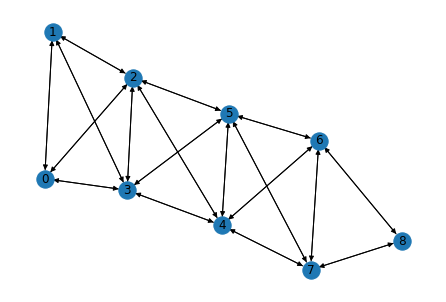

In [7]:
g = torch_geometric.utils.to_networkx(dataset_loader[0])
nx.draw(g, with_labels = True)

<AxesSubplot:xlabel='timestamp'>

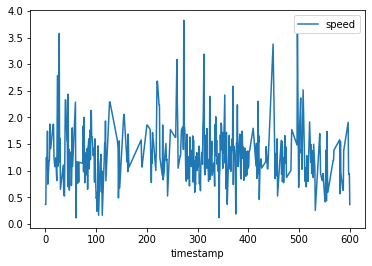

In [8]:
# visualize average crowd speed (ie flow?) in each zone over time
zone_number = 0
time = 60*10 # seconds

x1, y1, x2, y2 = ZONE_LIST[zone_number]
full_df = pd.concat(trajs)
full_df['speed'] = np.sqrt(full_df['vel_x']**2 + full_df['vel_y']**2)
sub_df = full_df[(full_df['pos_x'] > x1) & 
                 (full_df['pos_x'] < x2) & 
                 (full_df['pos_y'] > y1) & 
                 (full_df['pos_y'] < y2) & 
                 (full_df['timestamp'] <= time)
                ]
time_vs_vel = sub_df.groupby("timestamp", as_index=False)['speed'].mean()
time_vs_vel.plot(x="timestamp", y = "speed")

In [9]:
# Test Train Split

train_loader, val_loader = temporal_signal_split(dataset_loader, train_ratio=0.8)

print("Number of train buckets: ", len(set(train_loader)))
print("Number of test buckets: ", len(set(val_loader)))

Number of train buckets:  4138
Number of test buckets:  1035


# Train with Lightning (no batch)

In [89]:
class LitWrapper(pl.LightningModule): 
    def __init__(self, model): 
        super().__init__()
        self.model = model
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer
    
    def _shared_step(self, batch, batch_idx): 
        h = self.model(batch.x, batch.edge_index, batch.edge_attr)
        return h
    
    def training_step(self, batch, batch_idx): 
        h = self._shared_step(batch, batch_idx)
        y = batch.y
        loss = self._get_loss(h, y)
        return loss
        
    def validation_step(self, batch, batch_idx):
        h = self._shared_step(batch, batch_idx)
        y = batch.y
        loss = self._get_loss(h, y)
        metrics = {'val_loss': loss}
        self.log_dict(metrics)
        return metrics
    
    def test_step(self, batch, batch_idx) :
        h = self._shared_step(batch, batch_idx)
        y = batch.y
        loss = self._get_loss(h, y)
        metrics = {'test_loss': loss}
        self.log_dict(metrics)
        return metrics
    
    def prediction_step(self, batch, batch_idx): 
        h = self._shared_step(batch, batch_idx)
        return h
        
    def _get_loss(self, h, y): 
        return F.mse_loss(h, y)

In [19]:
from torch_geometric_temporal.nn.recurrent import *
from torch_geometric_temporal.nn.attention import *

class A3TGCN_1(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(A3TGCN_1, self).__init__()
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_weight):
        h = self.tgnn(x, edge_index) # no edge weight in this dataset
        h = F.relu(h)
        h = self.linear(h)
        return h

class RecurrentGCN(torch.nn.Module):
    def __init__(self, periods):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(in_channels=periods, 
                                  out_channels=32, 
                                  K = 16)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x[:,0,:], edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h
    
class TGCN_1(torch.nn.Module):
    def __init__(self, periods):
        super(TGCN_1, self).__init__()
        self.tgnn = TGCN(in_channels=periods, 
                         out_channels=32)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_weight):
        h = self.tgnn(x[:,0,:], edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

class MPNNLSTM_(torch.nn.Module): 
    def __init__(self, periods, num_nodes):
        super(MPNNLSTM_, self).__init__()
        self.tgnn = MPNNLSTM(in_channels=periods, 
                             hidden_size=128,
                             out_channels=32, 
                             num_nodes=num_nodes, 
                             window=1, 
                             dropout=0.5)
        self.linear = torch.nn.Linear(2*128+periods, periods)

    def forward(self, x, edge_index, edge_weight):
        h = self.tgnn(x[:,0,:], edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
    
class DCRNN_(torch.nn.Module): 
    def __init__(self, periods):
        super(DCRNN_, self).__init__()
        self.tgnn = DCRNN(in_channels=periods, 
                          out_channels=32, 
                          K=16)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_weight):
        h = self.tgnn(x[:,0,:], edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h
    


In [21]:
early_stop_callback = EarlyStopping(monitor='val_loss',
                                    min_delta=0.00,
                                    patience=10,
                                    verbose=True,
                                    mode='min') # why the hell is this max 

In [150]:
for m in [A3TGCN_1(node_features=2, periods=20),
          RecurrentGCN(periods=20),
          TGCN_1(periods=20),
          MPNNLSTM_(periods=20, num_nodes=len(ZONE_LIST)),
          DCRNN_(periods=20)
         ]: 
    model = LitWrapper(m)
    logger = pl.loggers.TensorBoardLogger(save_dir = "./lightning_logs/flow_forecasting",name=m.__class__.__name__)
    trainer = pl.Trainer(callbacks=[early_stop_callback],
                         auto_lr_find=True,
                         logger = logger,
                         gpus=1,
                         accelerator='gpu',
#                          fast_dev_run=10
                        )
    trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | A3TGCN_1 | 7.2 K 
-----------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.934


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.168 >= min_delta = 0.0. New best score: 1.766


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 1.635


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.236 >= min_delta = 0.0. New best score: 1.399


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.381


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.365 >= min_delta = 0.0. New best score: 1.016


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.016. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | RecurrentGCN | 80.7 K
---------------------------------------
80.7 K    Trainable params
0         Non-trainable params
80.7 K    Total params
0.323     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 11 records. Best score: 1.016. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: ./lightning_logs/flow_forecasting/TGCN_1

  | Name  | Type   | Params
---------------------------------
0 | model | TGCN_1 | 8.9 K 
---------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.036     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 12 records. Best score: 1.016. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: ./lightning_logs/flow_forecasting/MPNNLSTM_

  | Name  | Type      | Params
------------------------------------
0 | model | MPNNLSTM_ | 354 K 
------------------------------------
354 K     Trainable params
0         Non-trainable params
354 K     Total params
1.420     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 13 records. Best score: 1.016. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: ./lightning_logs/flow_forecasting/DCRNN_

  | Name  | Type   | Params
---------------------------------
0 | model | DCRNN_ | 160 K 
---------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.642     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 14 records. Best score: 1.016. Signaling Trainer to stop.


In [154]:
for m in [A3TGCN_1(node_features=2, periods=20),
          RecurrentGCN(periods=20),
          TGCN_1(periods=20),
          MPNNLSTM_(periods=20, num_nodes=len(ZONE_LIST)),
          DCRNN_(periods=20)
         ]: 
    model = LitWrapper(m)
    logger = pl.loggers.TensorBoardLogger(save_dir = "./lightning_logs/flow_forecasting",name=m.__class__.__name__)
    trainer = pl.Trainer(callbacks=[early_stop_callback],
                         auto_lr_find=True,
                         logger = logger,
                         gpus=1,
                         accelerator='gpu',
#                          fast_dev_run=10
                        )
    trainer.test(model, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.128106117248535}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.1968209743499756}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.16190505027771}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2183878421783447}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 2.2474303245544434}
--------------------------------------------------------------------------------


In [188]:
# testing lightinig model
loss_fn = torch.nn.MSELoss()

for snapshot in val_loader:
    static_edge_index = snapshot.edge_index.to('cuda')
    break;
m.to('cuda')
m.eval()
step = 0
# Store for analysis
total_loss = []
for snapshot in val_loader:
    # Get model predictions
    y_hat = m(snapshot.x.to('cuda'), static_edge_index, None)
    # Mean squared error
    loss = loss_fn(y_hat, snapshot.y.to('cuda'))
    print(loss)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

tensor(0.5471, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5341, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5468, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5463, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5443, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5431, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5449, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5612, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5680, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5726, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5688, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5713, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5640, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5736, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5645, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5562, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5741, device='cuda:0', grad_fn=<MseLossBackward

tensor(0.9391, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9646, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9752, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9743, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9787, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9867, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9823, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9916, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9942, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0114, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0397, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0648, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1145, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1329, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1602, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1693, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2236, device='cuda:0', grad_fn=<MseLossBackward

tensor(2.7194, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7167, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6867, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6557, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6597, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6647, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6352, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6301, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6461, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6384, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6507, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6764, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6825, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7258, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7593, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7671, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7579, device='cuda:0', grad_fn=<MseLossBackward

tensor(2.3113, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2326, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1710, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1387, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1346, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1405, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1437, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1541, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2268, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2417, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2363, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2689, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2691, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2778, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2854, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2996, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.3396, device='cuda:0', grad_fn=<MseLossBackward

tensor(6.1181, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(6.0429, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.9785, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.9144, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.8675, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.8075, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.7573, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.7079, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.6233, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.6044, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5590, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5911, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5447, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5212, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5554, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5507, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5720, device='cuda:0', grad_fn=<MseLossBackward

tensor(1.0205, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0371, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0874, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1200, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1714, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1967, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2158, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2584, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2884, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2979, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.3177, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.3639, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.4016, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.4261, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.4501, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.5091, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.5684, device='cuda:0', grad_fn=<MseLossBackward

tensor(0.6024, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5770, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5719, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5729, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5728, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5733, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5786, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5839, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5917, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5930, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.6074, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.6121, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.6223, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.6319, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.6407, device='cuda:0', grad_fn=<MseLossBackward

tensor(0.9822, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9886, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9901, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9943, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9951, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9943, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9957, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9980, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0044, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0065, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0079, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0080, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0108, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0110, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0138, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0140, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0153, device='cuda:0', grad_fn=<MseLossBackward

In [186]:
# testing lightning model
model = LitWrapper(m)
loss_fn = torch.nn.MSELoss()

for snapshot in val_loader:
    static_edge_index = snapshot.edge_index.to('cuda')
    break;
    
model.to('cuda')
model.eval()
step = 0
# Store for analysis
total_loss = []
for i,snapshot in enumerate(val_loader):
    # Get model predictions
    y_hat = model._shared_step(snapshot.to('cuda'),i)
#     # Mean squared error
    loss = loss_fn(y_hat, snapshot.y)
    print(loss)
    print()
    print(model._get_loss(y_hat, snapshot.y))
#     metrics = model.test_step(snapshot.to('cuda'),i)
#     print(metrics['test_loss'])
#     total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

tensor(0.5471, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.5471, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5341, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.5341, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5468, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.5468, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5463, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.5463, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5443, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.5443, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5431, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.5431, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5449, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.5449, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5612, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.5612, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5680, device='cuda:0', grad_fn=<MseLoss

tensor(0.7926, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.7926, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.7858, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.7858, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.7962, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.7962, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8038, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8038, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8109, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8109, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8127, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8127, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8404, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8404, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8461, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8461, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8616, device='cuda:0', grad_fn=<MseLoss

tensor(1.2538, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2692, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2692, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2710, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2710, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2696, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2696, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2779, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2779, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2806, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2806, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2714, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2714, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2879, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2879, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2653, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2653, device='cuda:0', grad_fn=<MseLoss

tensor(2.8551, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.8551, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.8882, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.8882, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.9215, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.9215, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.9620, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.9620, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.9784, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.9784, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.9612, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.9612, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.9651, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.9651, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.9585, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.9585, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.9107, device='cuda:0', grad_fn=<MseLoss

tensor(2.7144, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7248, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.7248, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6714, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.6714, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6331, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.6331, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.5562, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.5562, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.5312, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.5312, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.5119, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.5119, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.4844, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.4844, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.4498, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.4498, device='cuda:0', grad_fn=<MseLoss

tensor(2.7794, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.7794, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7979, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.7979, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7665, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.7665, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7542, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.7542, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7130, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.7130, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.7070, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.7070, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6818, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.6818, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.6145, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.6145, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.5896, device='cuda:0', grad_fn=<MseLoss

tensor(5.1782, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.1782, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.3401, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.3401, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.4759, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.4759, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.6298, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.6298, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.7696, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.7696, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.9534, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.9534, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(6.1315, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(6.1315, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(6.2899, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(6.2899, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(6.5041, device='cuda:0', grad_fn=<MseLoss

tensor(5.7079, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.6233, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.6233, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.6044, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.6044, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5590, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.5590, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5911, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.5911, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5447, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.5447, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5212, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.5212, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5554, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.5554, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.5507, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(5.5507, device='cuda:0', grad_fn=<MseLoss

tensor(1.4047, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.4047, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.3673, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.3673, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.3405, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.3405, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.3009, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.3009, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2704, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2704, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2613, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2613, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2216, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.2216, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1974, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.1974, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1996, device='cuda:0', grad_fn=<MseLoss

tensor(2.0757, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.0757, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1055, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.1055, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1600, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.1600, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1899, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.1899, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2242, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.2242, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2545, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.2545, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2880, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.2880, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2932, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.2932, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.3062, device='cuda:0', grad_fn=<MseLoss

tensor(2.5594, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.4638, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.4638, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.3608, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.3608, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.2340, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.2340, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.1633, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.1633, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(2.0464, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(2.0464, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.9639, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.9639, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.8382, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.8382, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.7629, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(1.7629, device='cuda:0', grad_fn=<MseLoss

tensor(0.8216, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8216, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8209, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8209, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8200, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8200, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8187, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8187, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8177, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8177, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8185, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8185, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8215, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8215, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8283, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.8283, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8271, device='cuda:0', grad_fn=<MseLoss

tensor(0.9979, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9923, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.9923, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9869, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.9869, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9796, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.9796, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9798, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.9798, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9810, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.9810, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9801, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.9801, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9812, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.9812, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.9826, device='cuda:0', grad_fn=<MseLossBackward>)

tensor(0.9826, device='cuda:0', grad_fn=<MseLoss

ZeroDivisionError: division by zero

In [181]:
y_hat.shape, snapshot.y.shape

(torch.Size([9, 20]), torch.Size([9, 20]))

In [194]:
# testing lightinig model 
m.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_dataset_new:
    # Get model predictions
    y_hat = m(encoder_inputs, static_edge_index,None)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 2.2474


# Two features (only supports a3tgcn2 for now)

In [195]:
# GPU support
DEVICE = torch.device('cuda') # cuda
shuffle=True
batch_size = 2

In [ ]:
loader = GCSDatasetLoaderStatic(
    trajs=trajs,
    ZONE_LIST = ZONE_LIST)

In [74]:
dataset = loader.get_dataset(num_timesteps_in=20, num_timesteps_out=20)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(set(dataset)))
print(next(iter(dataset))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f0ad7405518>
Number of samples / sequences:  5173
Data(x=[9, 2, 20], edge_index=[2, 36], edge_attr=[36], y=[9, 20])


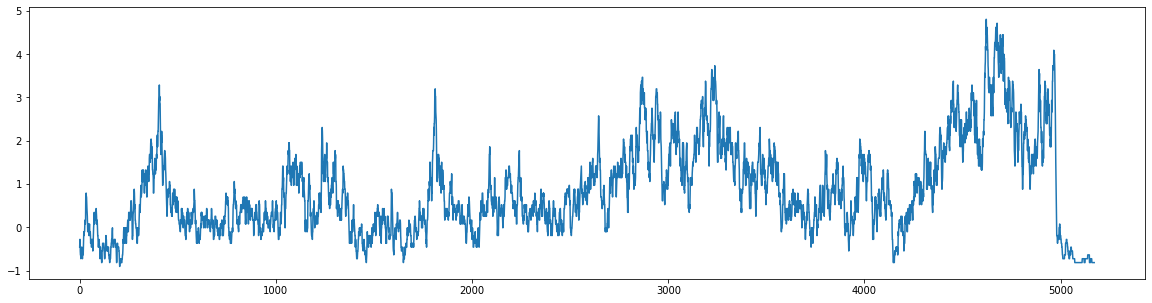

In [75]:
# Visualize traffic over time
plt.figure(figsize=(20,5))
sensor_number = 8
time = -1
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:time]]
plt.plot(sensor_labels)

In [76]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(set(train_dataset)))
print("Number of test buckets: ", len(set(test_dataset)))

Number of train buckets:  4138
Number of test buckets:  1035


In [77]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [78]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [16]:
class A3TGCN_2(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(A3TGCN_2, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

In [574]:
# Create model and optimizers
model = A3TGCN_2(node_features=2, periods=20, batch_size=batch_size).to(DEVICE)
loss_fn = torch.nn.MSELoss()

print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([20])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([20, 32])
linear.bias 	 torch.Size([20])
Net's total params: 7208
Optimizer's state_dict:
state 	 {0: {'step': 1415, 'exp_avg': tensor([ 3.9141e-04,  3.7302e-04,  4.5722e-04,  2.4940e-04,  1.9533e-04,
         2.5176e-04,  1.7831e-04,  3.6030e-04,  1.9210e-04,  1.6139e-04,
         1.1489e-04,  1.6

In [575]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [576]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(100):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.7271435675024986
0.6960385097563266
0.6885111689567566
0.6664313829690218
0.6486890341043472
0.6217527946581444
0.5979468892940453
0.5753990151919425
0.5511915760984023
0.5291527059450746
0.5102159682187167
0.49417407607038816
0.48005425582711514
0.4672453085439546
0.45646400223175687
0.44480394506827
0.4367006367006723
0.42916389918989606
0.4219190444483569
0.415505181774497
Epoch 0 train RMSE: 0.4115
0.269264422878623
0.27894789714366197
0.28669259438912076
0.2864980696514249
0.2922489742934704
0.29102730881422756
0.29071280286780427
0.2897987487912178
0.28907454658713605
0.2892390965372324
0.28936084659262135
0.29002353847647705
0.28956289674227054
0.29019625481750283
0.291086668630441
0.29050315203145144
0.28984984651646195
0.29130163232899375
0.29149649618095475
0.29083421019464734
Epoch 1 train RMSE: 0.2914
0.280531734675169
0.2810779498144984
0.288226200218002
0.2864982444792986
0.2883200589716434
0.28816040106117724
0.2877368648137365
0.2898506441991776
0.2910791934364372
0.2

0.27642205082294014
0.2760697423629463
0.2766657678681341
0.2773550742833565
0.2775861896889714
0.2773198084932353
0.2773784951493144
0.2774679388315417
0.2766549925089759
0.27698125656487216
0.27679877508039535
0.27774428024329245
Epoch 20 train RMSE: 0.2781
0.28379348151385786
0.28239193979650734
0.2816600012530883
0.2837893704511225
0.2829364343434572
0.28503433216363194
0.28539547719061376
0.2823222199361771
0.283004687420196
0.2816018790230155
0.28296927033500235
0.2833859359597166
0.2819418021520743
0.28152984312070267
0.2802382354785999
0.279906705992762
0.2797386062583503
0.27892343123753865
0.27880971629760765
0.2786069979406893
Epoch 21 train RMSE: 0.2779
0.2870994622260332
0.27461813915520905
0.27554135481516523
0.2800550258718431
0.2773850563466549
0.2773122002805273
0.279035157465509
0.27760114304721356
0.27906015085677305
0.27822505781799556
0.27722623277116903
0.2780694464966655
0.27939780669143566
0.27816353371100766
0.2783330786575874
0.2780992339644581
0.2782606353303

0.2820060134182374
0.28447621524333955
0.2837160037234426
0.28153297294552126
0.27846190838409324
0.2797239545313641
0.2777353478678399
0.27671022616699337
0.2748369299112396
0.27543470458127556
0.274648874410643
0.2738662356430931
0.2734574029420813
0.2732899609976448
0.2732985785099513
0.27307495527176395
0.2737964142525667
0.27501203802786767
Epoch 40 train RMSE: 0.2748
0.28345938719809055
0.2786167270317674
0.27797861116627853
0.27850545620545747
0.27307957379519937
0.2690376646940907
0.2704717133087771
0.2724344268348068
0.2726725131728583
0.27328278398886324
0.2719030619107864
0.2719964660424739
0.27302951289197575
0.27369938755940115
0.2753443721955021
0.27399533726507797
0.2744273589923978
0.27396833662978476
0.2745787241525556
0.2744116029087454
Epoch 41 train RMSE: 0.2747
0.27329344898462293
0.27029482919722797
0.27200519323349
0.2761706540547311
0.2752996135801077
0.2782635190958778
0.2762384769533362
0.2748947988357395
0.27548804595238635
0.27534470765292646
0.2757277881828

0.27315836936980487
Epoch 59 train RMSE: 0.2723
0.2675354078412056
0.26670468632131816
0.26730645678937437
0.26791603287681937
0.2697441772818565
0.2719915473957856
0.2700213287877185
0.2736458868440241
0.27330109586318335
0.2727563855201006
0.27259623297236185
0.27178201083714765
0.2713904060079501
0.27049679283584865
0.2710425698161125
0.2711272330954671
0.2709322235733271
0.2714231591423353
0.2715927591292482
0.27205726001784203
Epoch 60 train RMSE: 0.2722
0.2828260467201471
0.28292241115123035
0.28133859602113565
0.27953640738502145
0.28012794676423075
0.27684954803436995
0.27455374877899885
0.27477597990538927
0.27410696835567555
0.27370603225007656
0.2723204970664599
0.2705257118400186
0.2700878864555405
0.27036118170778667
0.2707505928352475
0.27070370022905993
0.27094242544516045
0.2708666040479309
0.2713794375348248
0.2715488854702562
Epoch 61 train RMSE: 0.2721
0.282654922157526
0.28480120465159414
0.2810554527988037
0.27742675103247166
0.2769805492460728
0.2756116833289464
0

0.2717231849609659
0.27057288401627116
0.27054336878905694
0.2701219400553964
0.2696573368613334
0.2700656770769921
0.2692808695117894
0.26998017575405536
Epoch 79 train RMSE: 0.2704
0.2744650283455849
0.2805862554162741
0.2763640915354093
0.2758198217023164
0.2769719915613532
0.27748144408687947
0.27668812125389064
0.2748472807696089
0.27338284843911725
0.2730156595297158
0.27210783595049925
0.2719857827698191
0.27302904999026884
0.27402578203805855
0.2734031043897073
0.2736013263463974
0.27165577178053996
0.27107026809619533
0.27078307682354197
0.2708156182616949
Epoch 80 train RMSE: 0.2703
0.2632184993475676
0.2665531662479043
0.2700799839446942
0.2704369781538844
0.2700343525707722
0.27248955473303793
0.27154611605618684
0.27127659630961715
0.27014498537613285
0.27110253397375345
0.2713839637962255
0.2712436536451181
0.2707170281387292
0.270306298072849
0.2704765992810329
0.26980444823857397
0.26942874315906973
0.26975500029408267
0.2701629258104061
0.2702754733376205
Epoch 81 trai

0.26923919492534226
0.26943121230229733
0.27106568557520705
0.2706795745790005
0.27047180057249287
0.26977351570501923
0.2683189670569622
0.2676738073570388
0.26742821006973583
0.26759479648433626
0.2670793722087846
0.26836291208449337
0.26896351144109903
0.2683816200233996
Epoch 99 train RMSE: 0.2688


In [564]:
filename = datetime.now().strftime('logs/batch_volume_forecasting/'+
                                   '%d-%m-%y-%H_%M_%S_'+
                                   model.__class__.__name__+'.pt')
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': sum(loss_list)/len(loss_list),
            }, filename)

In [ ]:
# # load checkpoint
# checkpoint = torch.load(?)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [ ]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

In [580]:
zone = 8
timestep = 19
preds = np.asarray([pred[zone][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[zone][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (2,)


<AxesSubplot:>

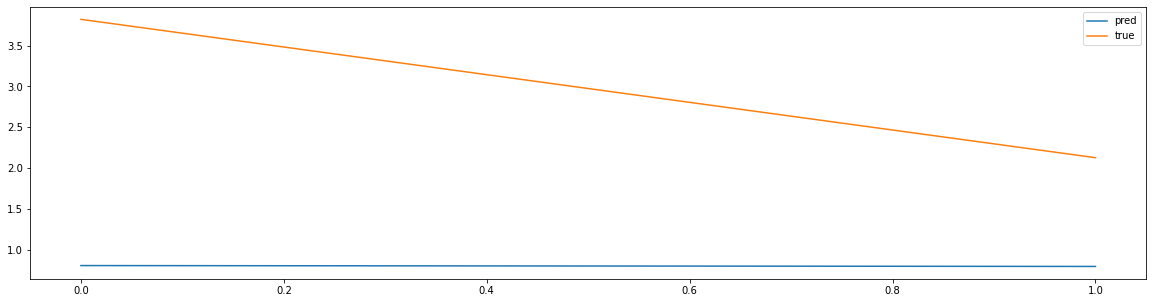

In [581]:
# visualize each graph
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

In [582]:
zone = 8
data_idx = 0
history = encoder_inputs[data_idx, zone,0,:].detach().cpu().numpy()
preds = y_hat[data_idx,zone,:].detach().cpu().numpy()
labs = labels[data_idx,zone,:].detach().cpu().numpy()
print("Data points:,", preds.shape)

Data points:, (20,)


<AxesSubplot:>

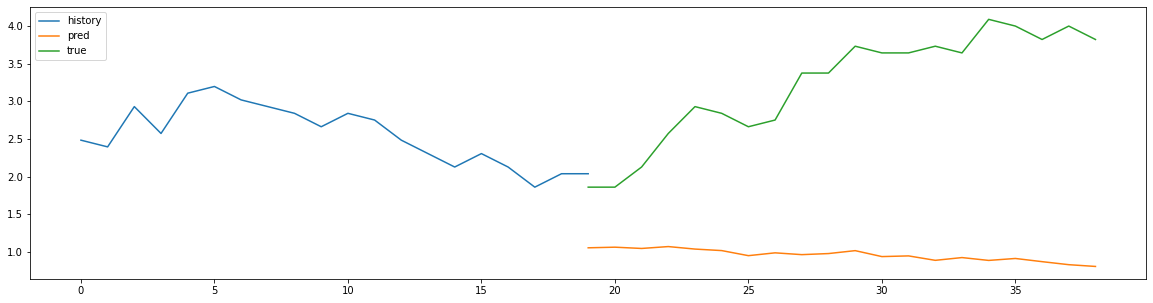

In [583]:
# visualize prediction over time 
plt.figure(figsize=(20,5))
sns.lineplot(x=range(20), y=history, label="history")
sns.lineplot(x=range(19,39), y=preds, label="pred")
sns.lineplot(x=range(19,39), y=labs, label="true")

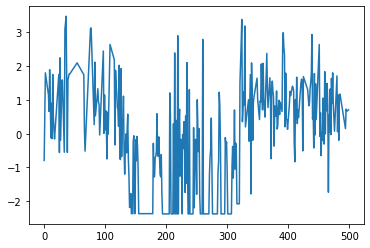

In [236]:
# Visualize traffic over time
zone = 1
timestep = 500
_labels = [batch.y[zone][0].item() for batch in list(dataset)[:timestep]]
plt.plot(_labels)

# Lightning Batch

In [10]:
from torch_geometric_temporal.nn.recurrent import *
from torch_geometric_temporal.nn.attention import *

class A3TGCN_2(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(A3TGCN_2, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = F.dropout(h, training = self.training, p=0.5)
        h = self.linear(h)
        return h



# class MTGNN_(torch.nn.Module): 
#     def __init__(self, num_nodes, node_features, periods, batch_size): 
#         super(MTGNN_, self).__init__()
#         self.tgnn = MTGNN(gcn_true = True,
#                           build_adj=True,
#                           gcn_depth = 2,
#                           num_nodes = num_nodes, 
#                           kernel_set = [3,3],
#                           kernel_size = [3,3],
#                           dropout = 0.2,
#                           subgraph_size = 5, 
#                           node_dim = 2, 
                          
#                           )
#         self.linear = torch.nn.Linear(32, periods)
#     def forward(self, x, edge_index): 
#         '''
#         x shape (B, N, F, T) -> (B, F, N, T)
#         '''
#         B,N,F,T = x.shape
#         x = x.view(B,F,N,T)
#         h = self.tgnn(x)
#         h = F.relu(h)
#         h = self.linear(h)
#         return h

In [144]:
class BatchLitDataModule(pl.LightningDataModule):
    '''input shape (B, N, F, T)
       target shape (B,N,T)
       '''
    def __init__(self, loader, batch_size = 32, shuffle = True):
        super().__init__()
        self.save_hyperparameters("batch_size", "shuffle")
        self.loader = loader
        self.batch_size = batch_size
        self.shuffle=shuffle

    def setup(self, stage = None):
        dataset = self.loader.get_dataset(num_timesteps_in=20, num_timesteps_out=20)
        
        train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)
        
        train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
        train_edge_index = np.array([train_dataset.edge_index]*len(train_dataset.features))
        train_edge_weight = np.array([train_dataset.edge_weight]*len(train_dataset.features))
        train_target = np.array(train_dataset.targets) # (27399, 207, 12)
        train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor) # (B, N, F, T)
        train_edge_index_tensor = torch.from_numpy(train_edge_index)
        train_edge_weight_tensor = torch.from_numpy(train_edge_weight)
        train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor)  # (B, N, T)
        self.train_dataset = torch.utils.data.TensorDataset(train_x_tensor, 
                                                            train_edge_index_tensor, 
                                                            train_edge_weight_tensor,
                                                            train_target_tensor)
        
        test_input = np.array(test_dataset.features) # (, 207, 2, 12)
        test_edge_index = np.array([test_dataset.edge_index]*len(test_dataset.features))
        test_edge_weight = np.array([test_dataset.edge_weight]*len(test_dataset.features))
        test_target = np.array(test_dataset.targets) # (, 207, 12)
        test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor)  # (B, N, F, T)
        test_edge_index_tensor = torch.from_numpy(test_edge_index)
        test_edge_weight_tensor = torch.from_numpy(test_edge_weight)
        test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor)  # (B, N, T)
        self.test_dataset = torch.utils.data.TensorDataset(test_x_tensor, 
                                                           test_edge_index_tensor, 
                                                           test_edge_weight_tensor,
                                                           test_target_tensor)
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset,
                                           batch_size=self.batch_size,
                                           shuffle=self.shuffle,
                                           drop_last=True,
                                           num_workers=4)

    def val_dataloader(self):
        return self.test_dataloader()

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset,
                                           batch_size=self.batch_size,
                                           shuffle=False,
                                           drop_last=True,
                                           num_workers=4)

class BatchLitWrapper(pl.LightningModule): 
    def __init__(self, model, lr): 
        super().__init__()
        self.save_hyperparameters("lr")
        self.model = model
        self.lr = lr
        
    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                                    mode='min',
                                                                    factor=0.2,
                                                                    verbose=True)
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.scheduler,
                "monitor": "val_loss"
                # If "monitor" references validation metrics, then "frequency" should be set to a
                # multiple of "trainer.check_val_every_n_epoch".
            },
        }
    
    def _shared_step(self, batch, batch_idx): 
        x, edge_index, edge_attr, labels = batch
        edge_index = edge_index[0,:,:] # because its static
        edge_attr = edge_attr[0,:]
        h = self.model(x, edge_index)
        return h, labels
    
    def training_step(self, batch, batch_idx): 
        h, y = self._shared_step(batch, batch_idx)
        loss = self._get_loss(h, y)
        metrics = {'train_loss': loss,
                   'lr': self.optimizer.param_groups[0]['lr']}
        self.log_dict(metrics)
        return loss
        
    def validation_step(self, batch, batch_idx):
        h, y = self._shared_step(batch, batch_idx)
        loss = self._get_loss(h, y)
        metrics = {'val_loss': loss}
        self.log_dict(metrics)
        return metrics
    
    def test_step(self, batch, batch_idx) :
        h, y = self._shared_step(batch, batch_idx)
        loss = self._get_loss(h, y)
        metrics = {'test_loss': loss}
        self.log_dict(metrics)
        return metrics
        
    def _get_loss(self, h, y): 
        return F.mse_loss(h, y)

In [145]:
# for lr in [0.017, 1e-2, 1e-3, 1e-4]:
#     for batch_size in [1,2,4,8,16,32,64,128,256,512]:
#         datamodule = BatchLitDataModule(loader, 
#                                         batch_size = batch_size, 
#                                         shuffle=True)
#         datamodule.setup()

#         for m in [A3TGCN_2(node_features=2, periods=20, batch_size=batch_size),
#                  ]: 
#             model = BatchLitWrapper(m, lr)
            
#             early_stop_callback = EarlyStopping(monitor='val_loss',
#                                     min_delta=0.00,
#                                     patience=10,
#                                     verbose=True,
#                                     mode='min') # why the hell is this max 
#             checkpoint_callback = ModelCheckpoint(save_last=True,
#                                                   verbose=True, 
#                                                   monitor='val_loss',
#                                                   mode='min')

#             logger = pl.loggers.TensorBoardLogger(save_dir = "./lightning_logs",name=m.__class__.__name__)
#             trainer = pl.Trainer(callbacks=[early_stop_callback,
#                                             checkpoint_callback],
#                                  logger = logger,
#                                  gpus=1,
#                                  accelerator='gpu',
# #                                  fast_dev_run=10
#                                 )
#             trainer.fit(model, datamodule=datamodule)

In [230]:
# testing all models
best_test_loss = 1e10

for root, dirs, files in tqdm(os.walk("lightning_logs")): 
    files = [f for f in files if not f[0] == '.']
    dirs[:] = [d for d in dirs if not d[0] == '.']
    
    if "version_1/" in root:
        for file in files:
            PATH = os.path.join(root, file)
            if file.endswith(".yaml"):
                # load hparams (should happen first before loading model & dm)
                hparams = load_hparams_from_yaml(PATH)

            if file.endswith(".ckpt"):
                # load model and datamodule
                datamodule = BatchLitDataModule(loader, 
                                                batch_size = hparams['batch_size'], 
                                                shuffle=False)
                datamodule.setup()

                m = A3TGCN_2(node_features=2, periods=20, batch_size=hparams['batch_size'])
                model = BatchLitWrapper.load_from_checkpoint(PATH,model=m)

                trainer = pl.Trainer(logger = False,
                                     gpus=1,
                                     accelerator='gpu',
    #                                  fast_dev_run=10
                                    )
                print(PATH)
                out = trainer.test(model,datamodule = datamodule)[0]
                if out['test_loss'] < best_test_loss:
                    best_test_loss = out['test_loss']
                    best_model_path = PATH
                    best_model = model
                    best_hparams = hparams
print(best_model_path)
print(best_hparams)

0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


lightning_logs/A3TGCN_2/version_1/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8321804404258728}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


lightning_logs/A3TGCN_2/version_1/checkpoints/epoch=6-step=14482.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6742954254150391}
--------------------------------------------------------------------------------
lightning_logs/A3TGCN_2/version_1/checkpoints/epoch=6-step=14482.ckpt
{'batch_size': 2, 'lr': 0.017, 'shuffle': True}


In [ ]:
print(best_test_loss, best_model_path)

In [ ]:
# plotting results from best model
hparams = best_hparams
model = best_model

datamodule = BatchLitDataModule(loader, 
                                batch_size = hparams['batch_size'], 
                                shuffle=False)
datamodule.setup()

model.eval()
model.freeze()


for batch_idx, batch in enumerate(datamodule.test_dataloader()):
    x, edge_index, edge_attr, _ = batch # x: (B, N, F, T)
    h, labels = model._shared_step(batch, batch_idx) # h: (B, N, T); labels: (B, N, T)
    print(F.mse_loss(h, labels))
    break
#     if batch_idx == 0:
#         break

In [ ]:
batch = 4

for zone in range(9):
    plt.figure(figsize=(50,5))
    history = x[batch, zone, 0, :]
    preds = h[batch, zone, :]
    labs = labels[batch, zone, :]

    sns.lineplot(x=range(20), y=history, label="history")
    sns.lineplot(x=range(20,40), y=preds, label="pred")
    sns.lineplot(x=range(20,40), y=labs, label="true")

In [209]:
# # lr finder
# trainer = pl.Trainer(callbacks=[early_stop_callback],
#                          auto_lr_find=True,
#                          logger = logger,
#                          gpus=1,
#                          accelerator='gpu')
# trainer.tune(model, datamodule=datamodule)

0it [00:00, ?it/s]

/home/vivian/anaconda3/envs/flow_predict/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


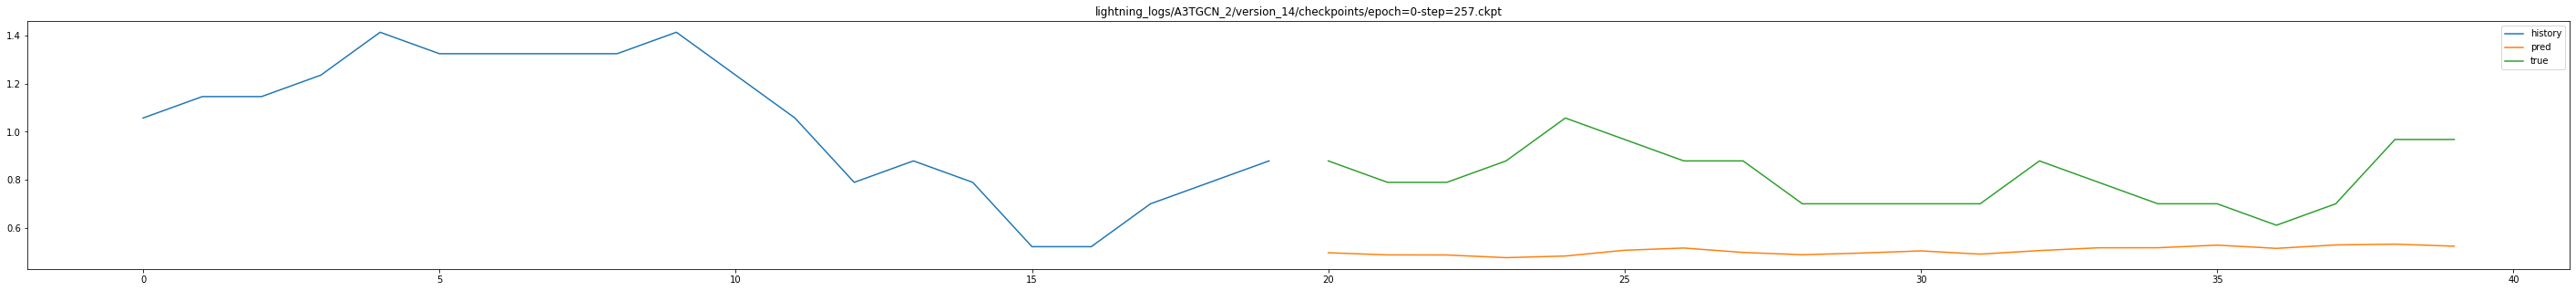

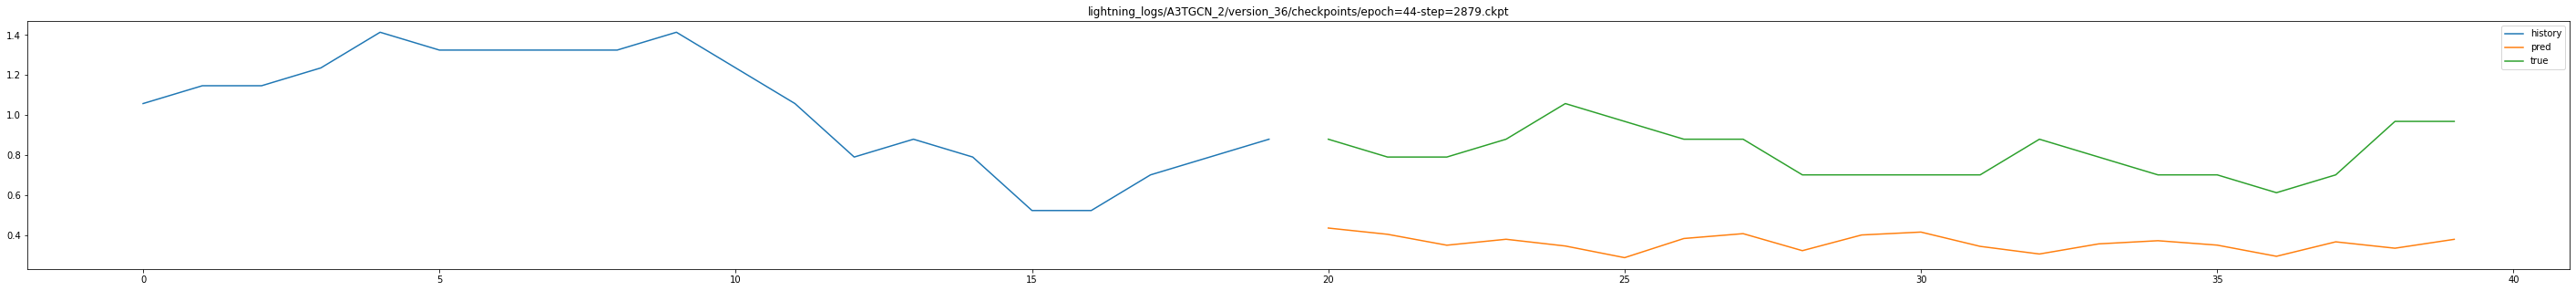

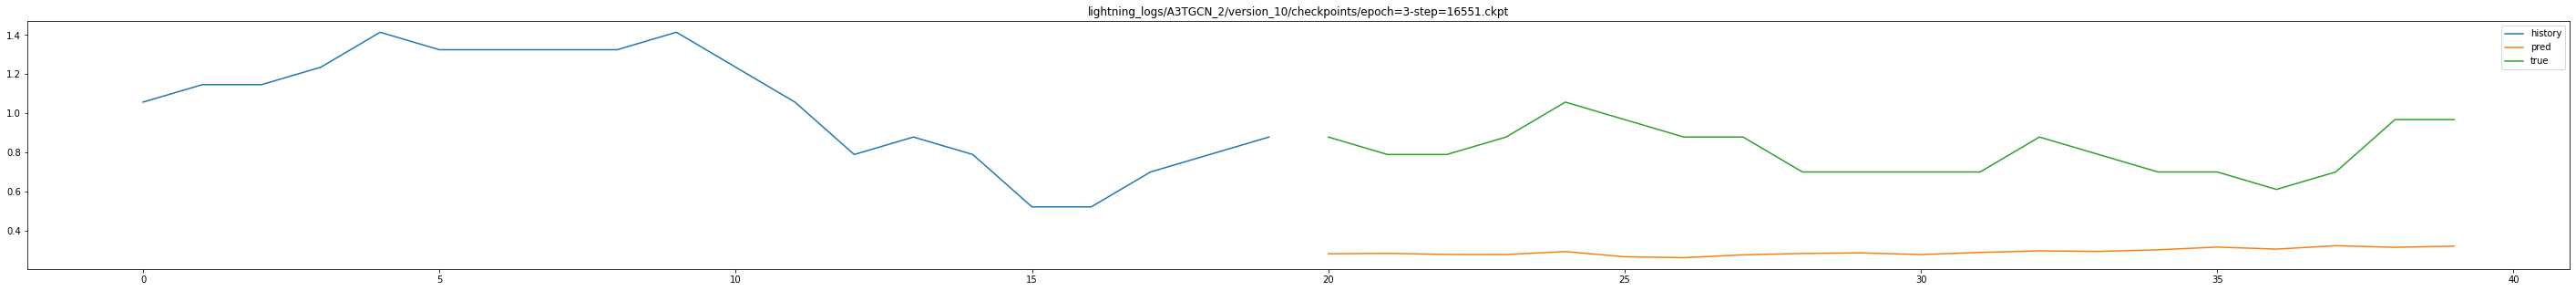

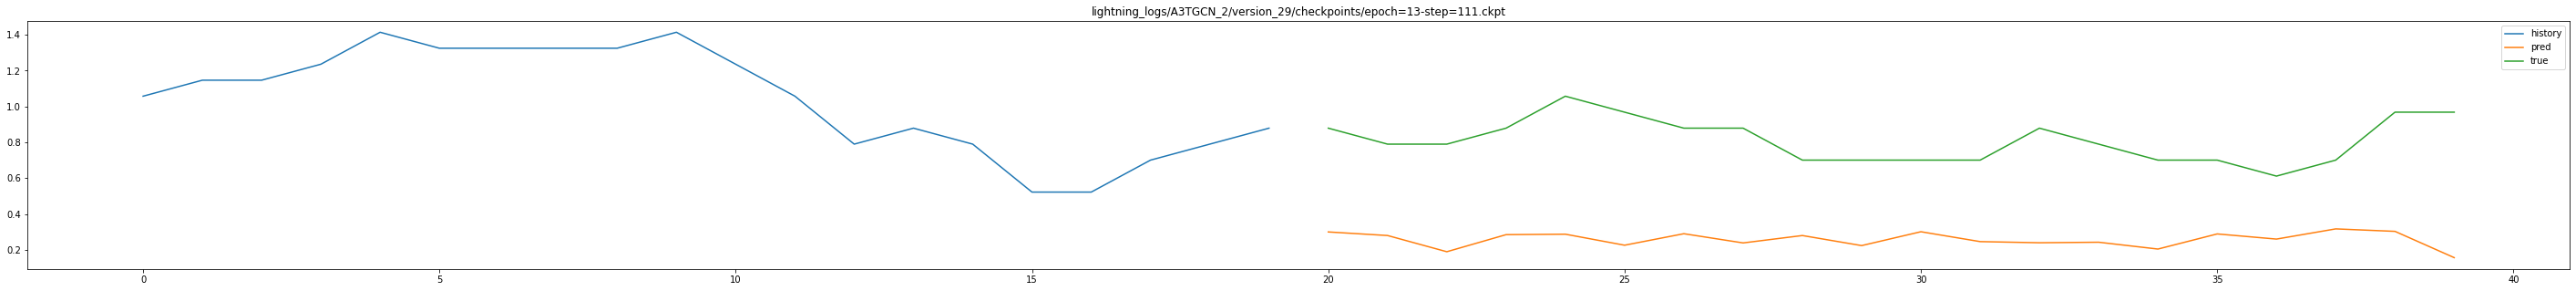

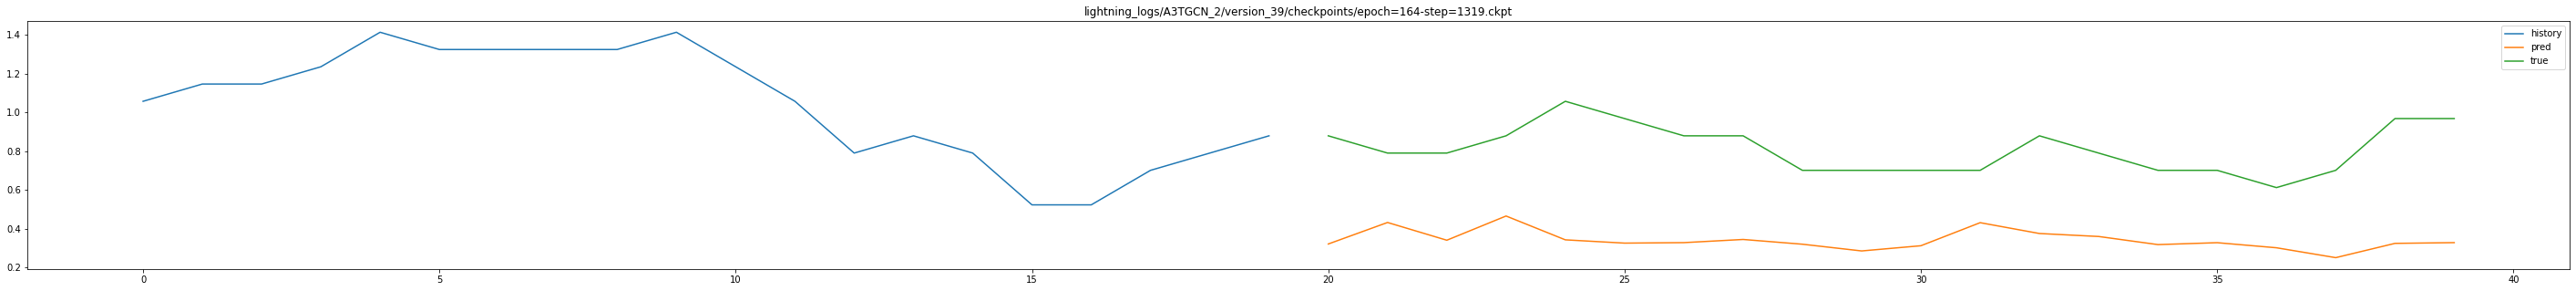

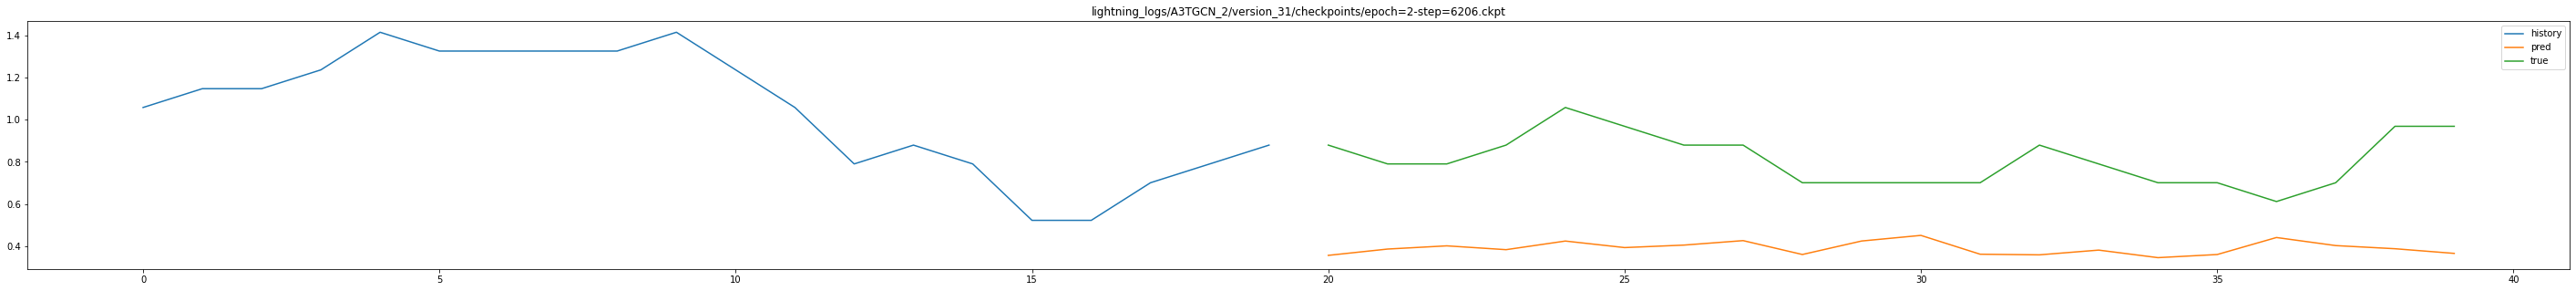

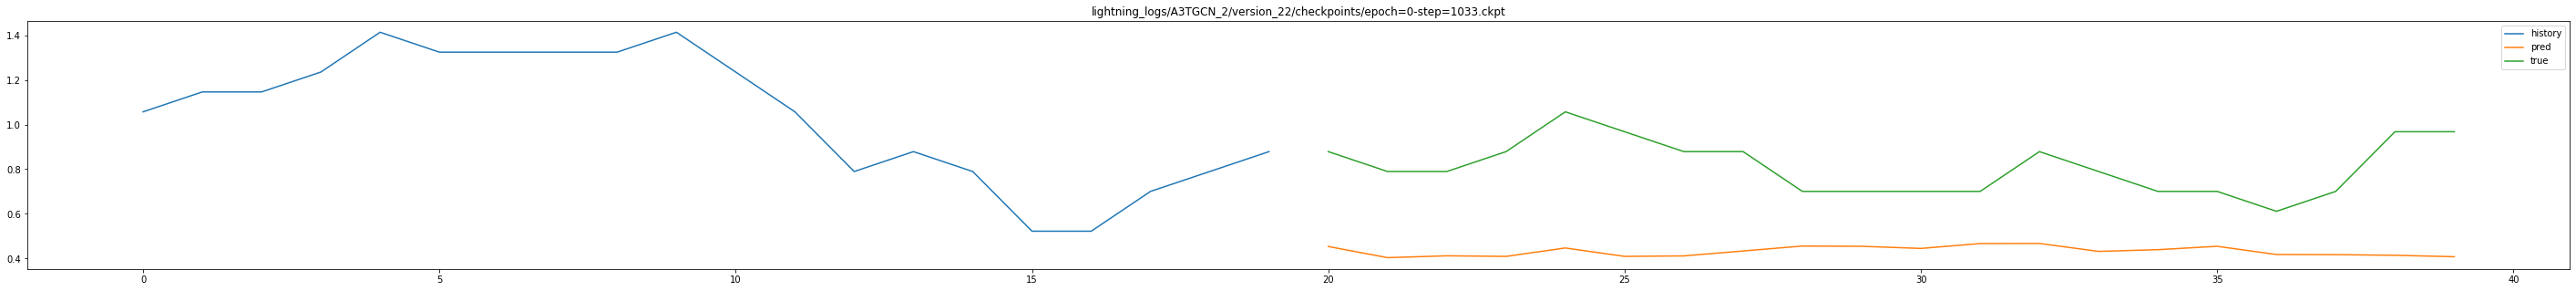

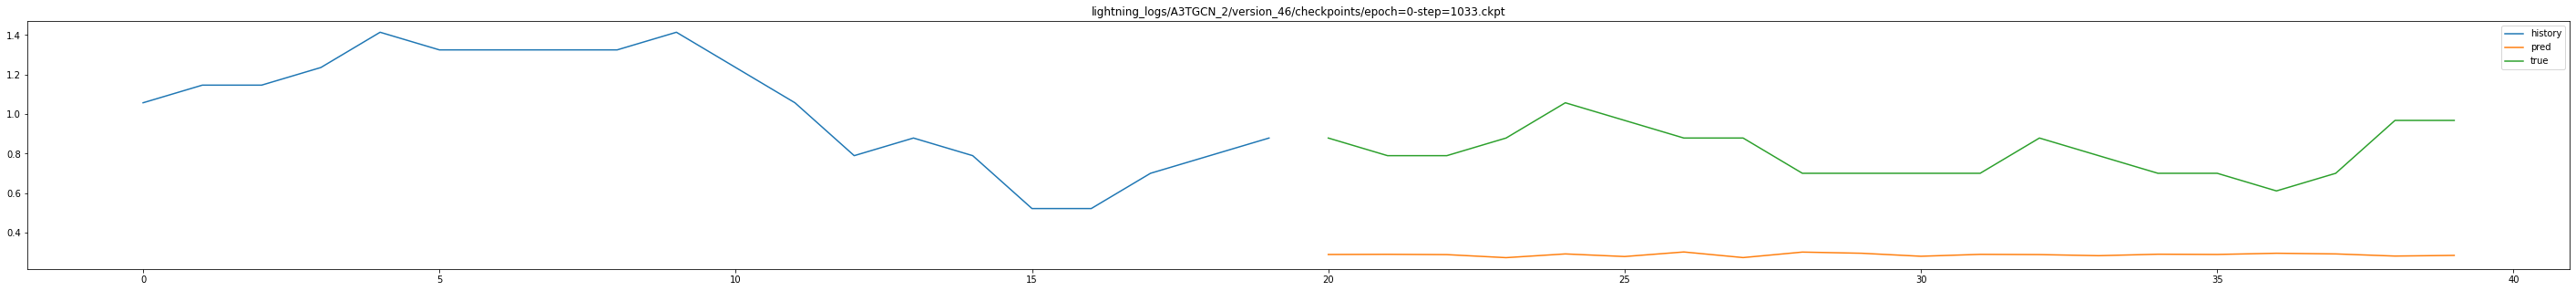

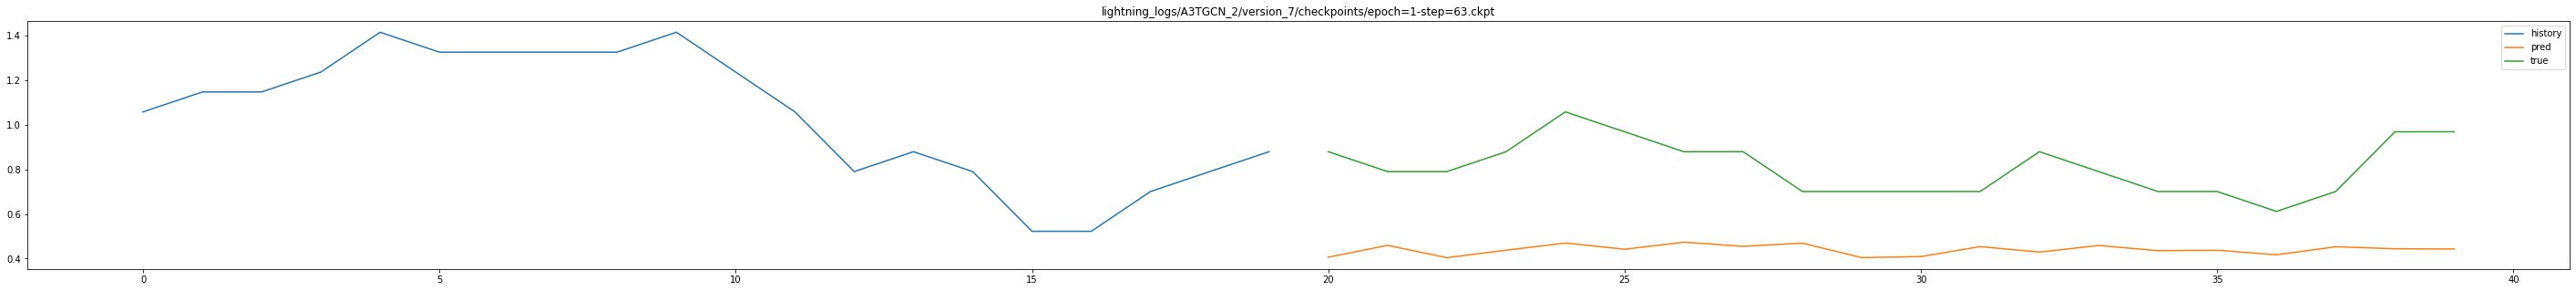

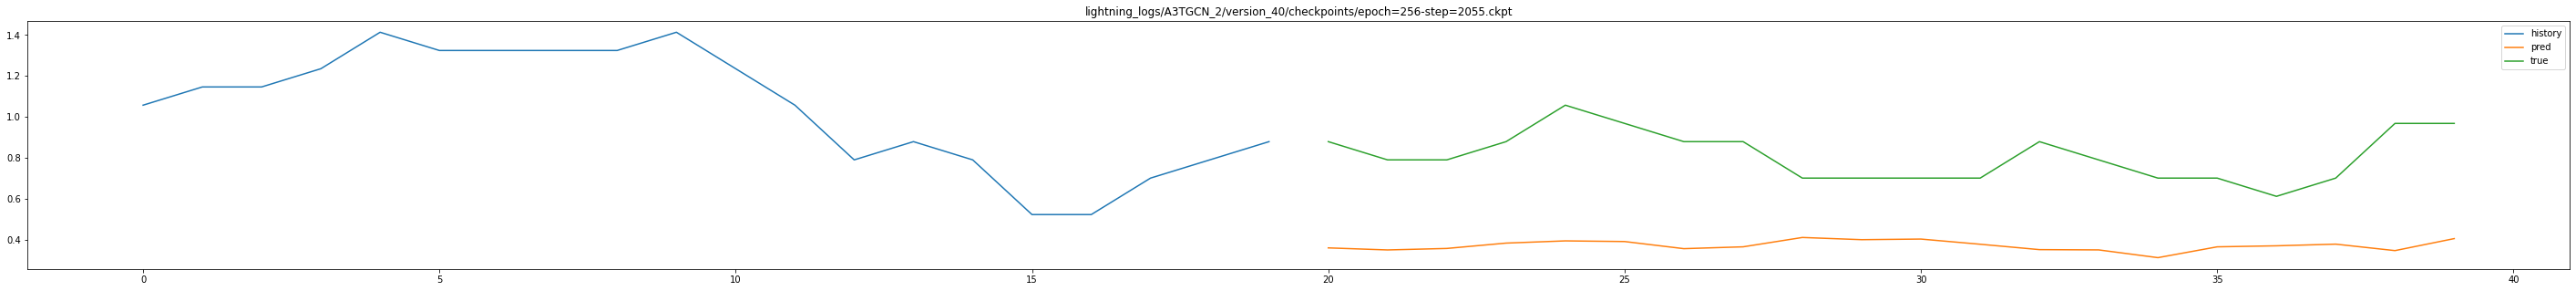

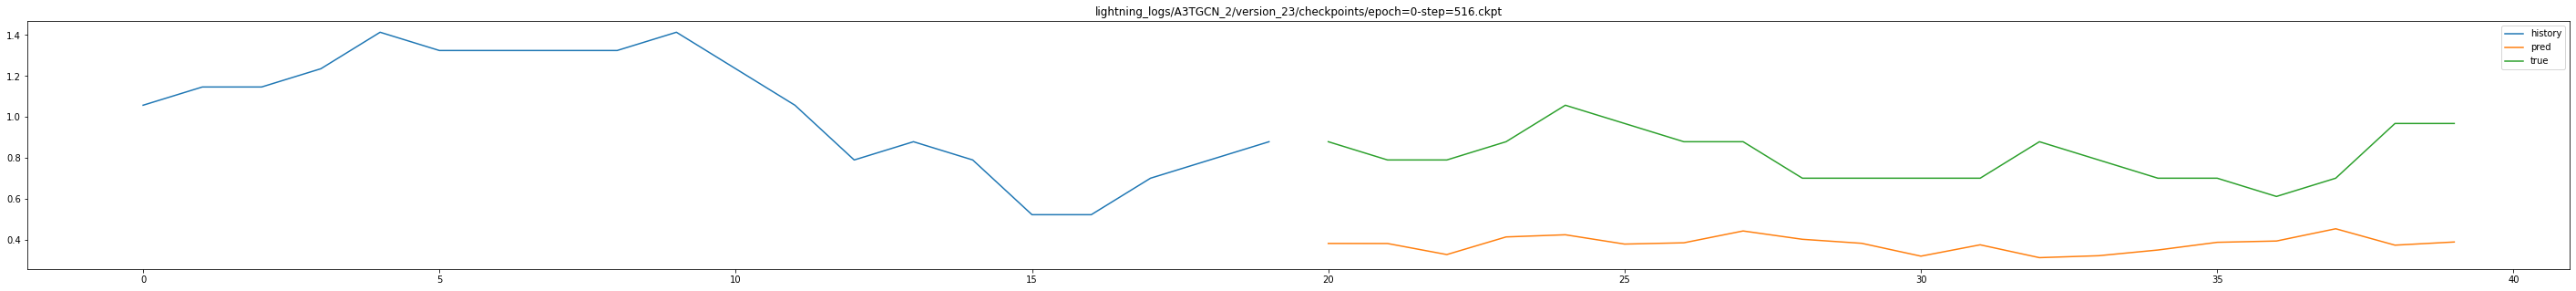

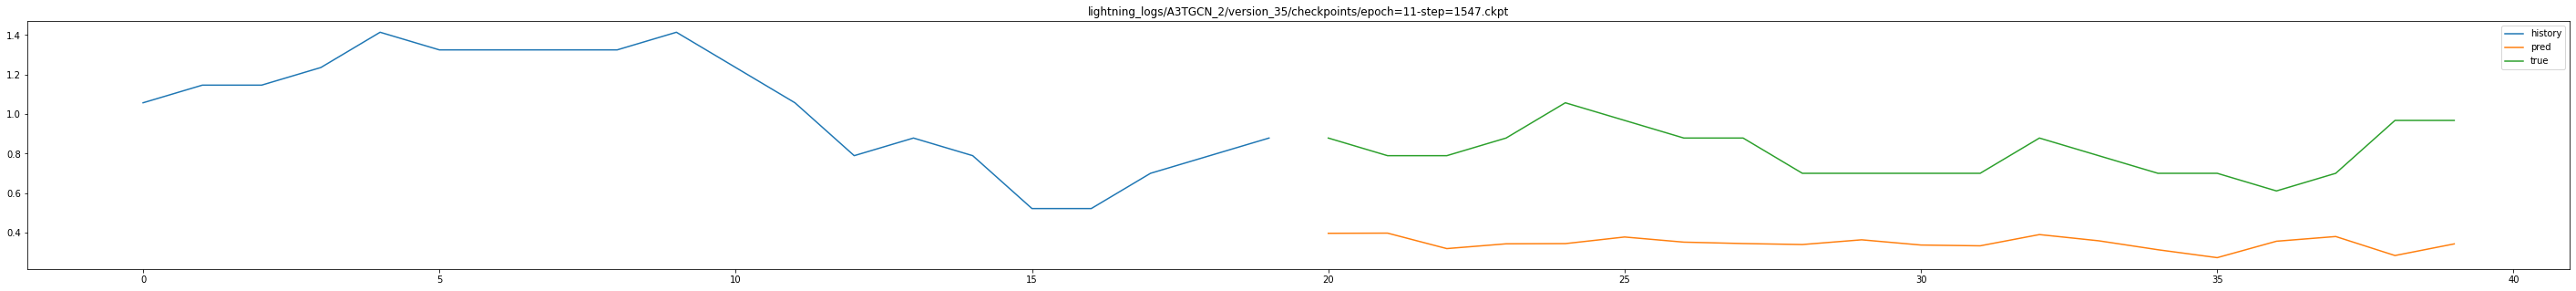

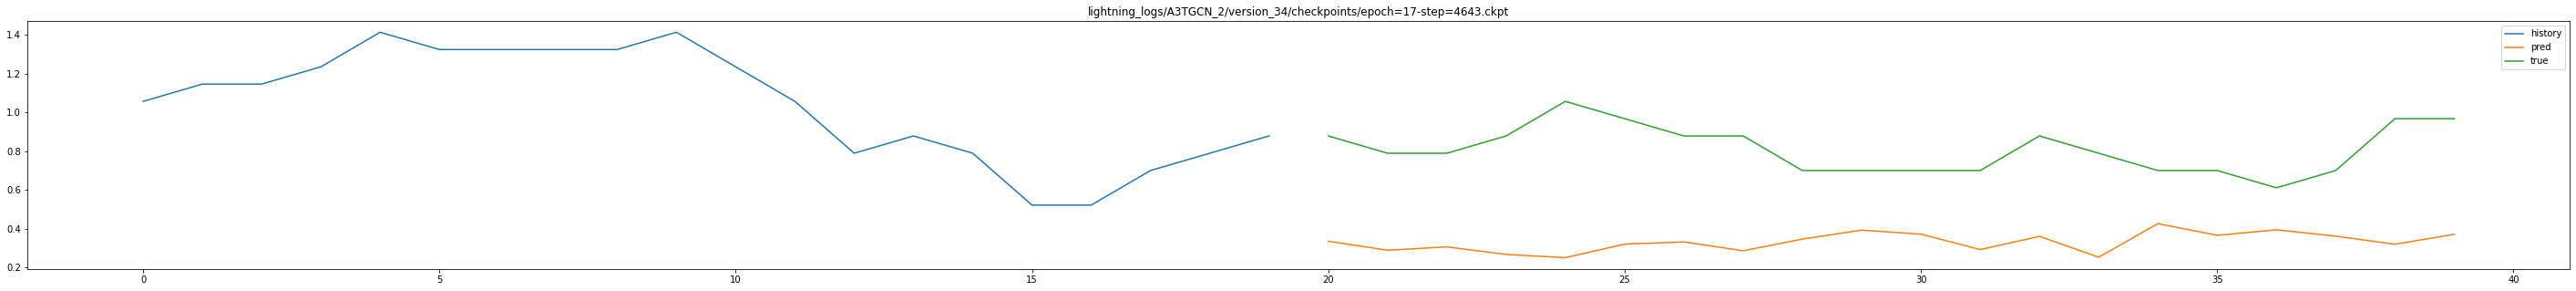

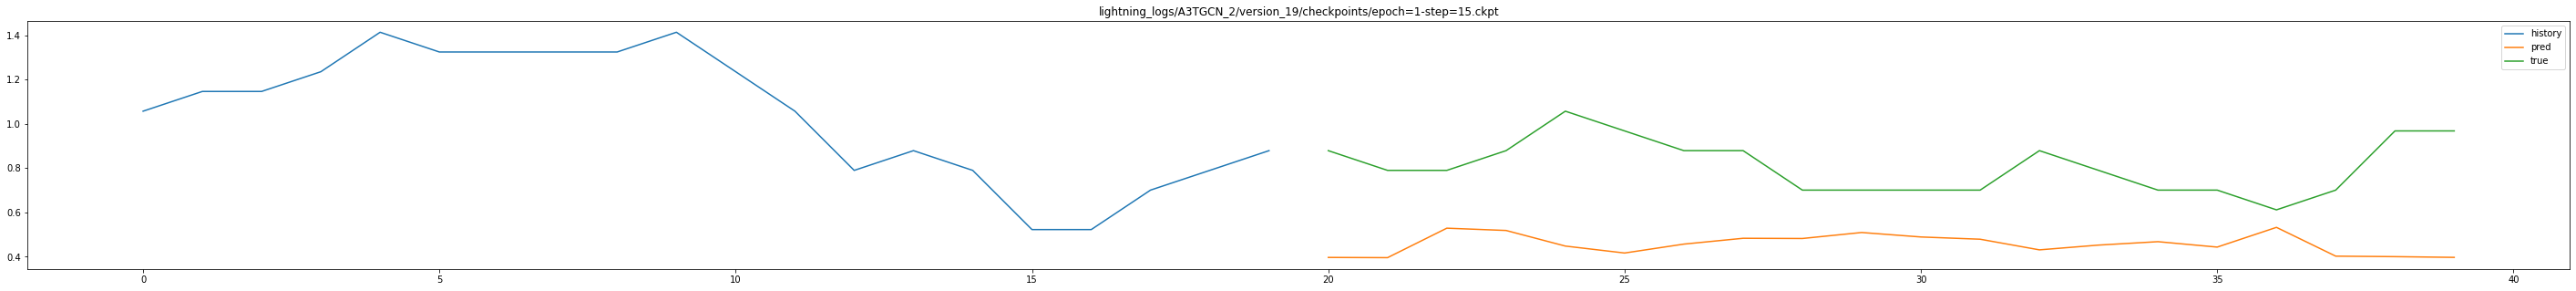

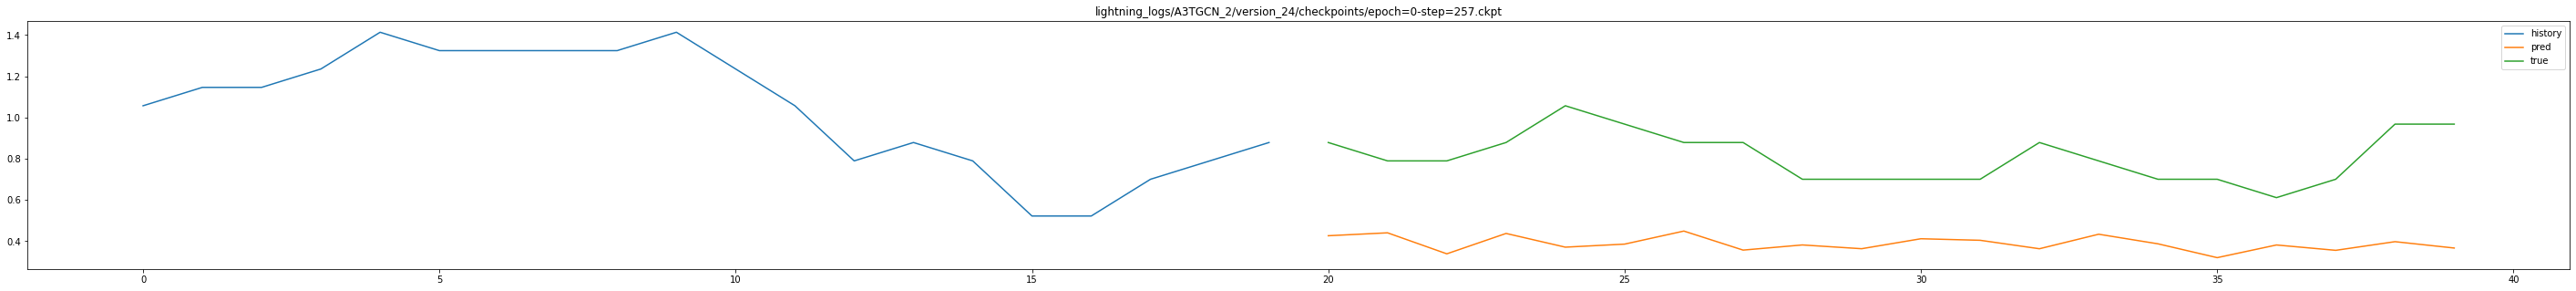

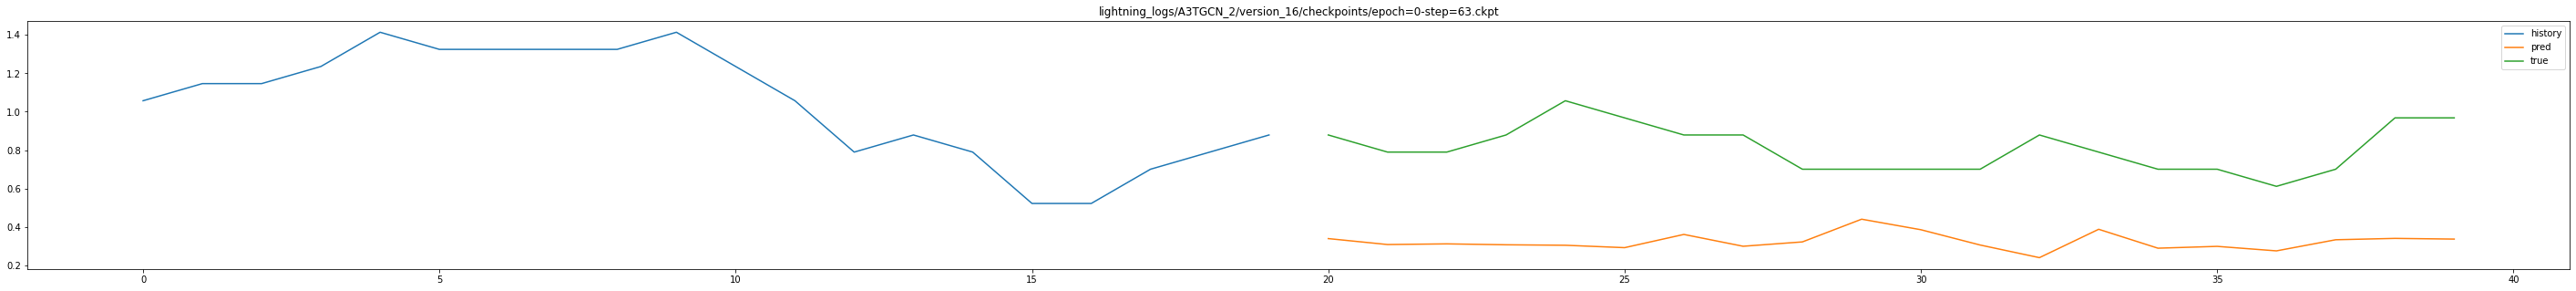

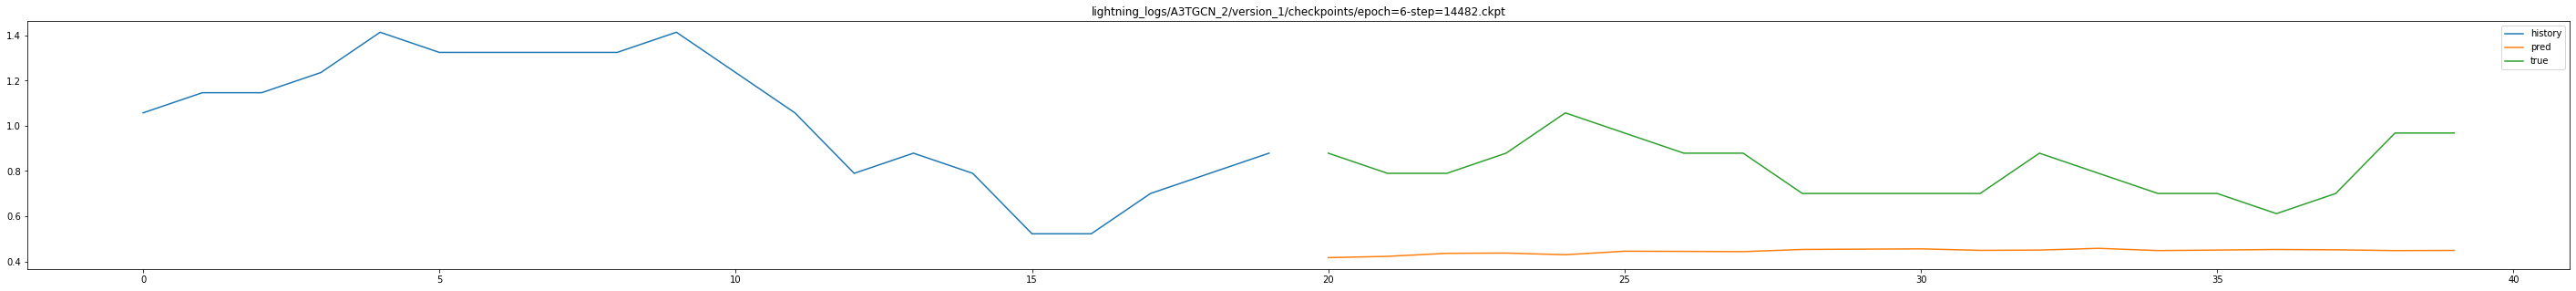

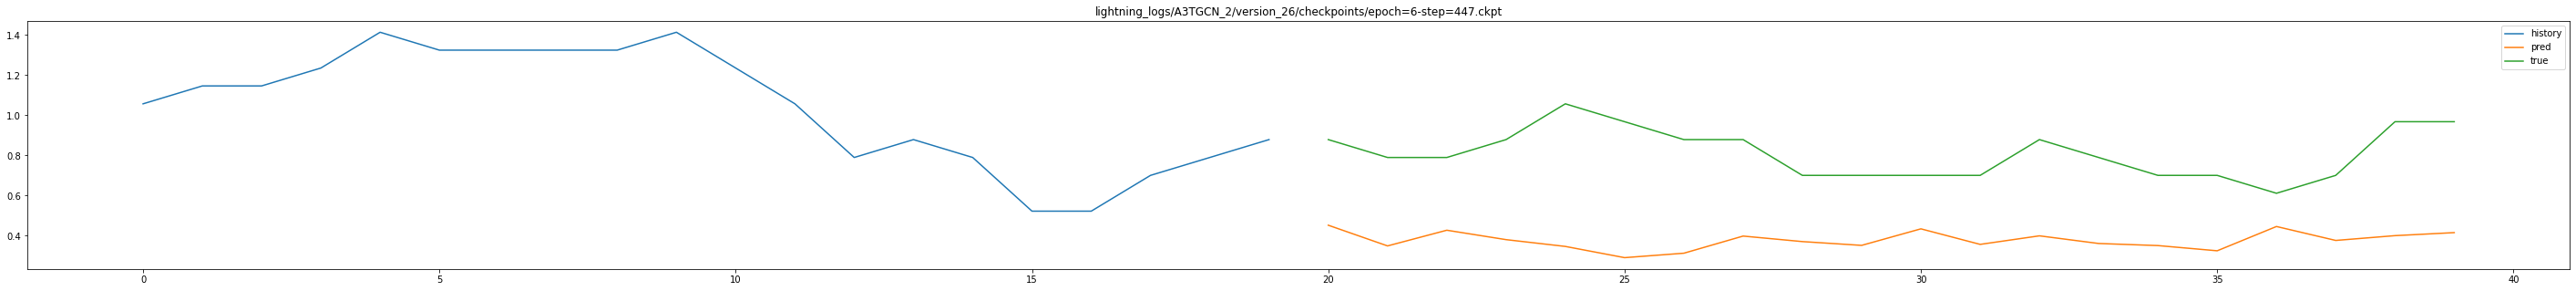

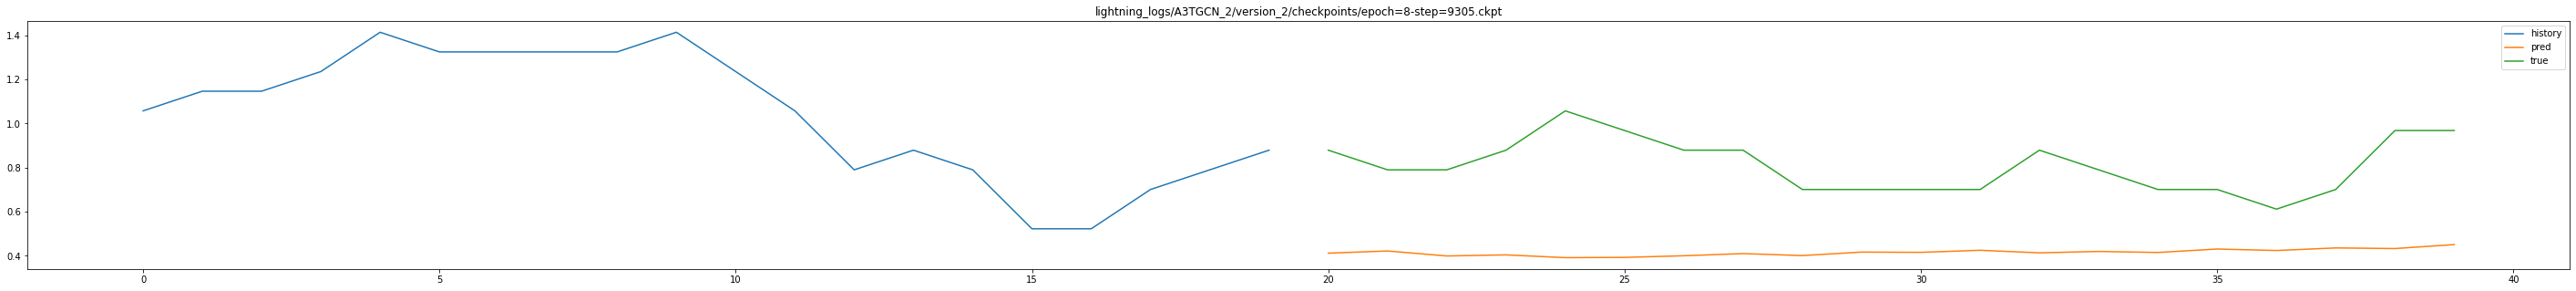

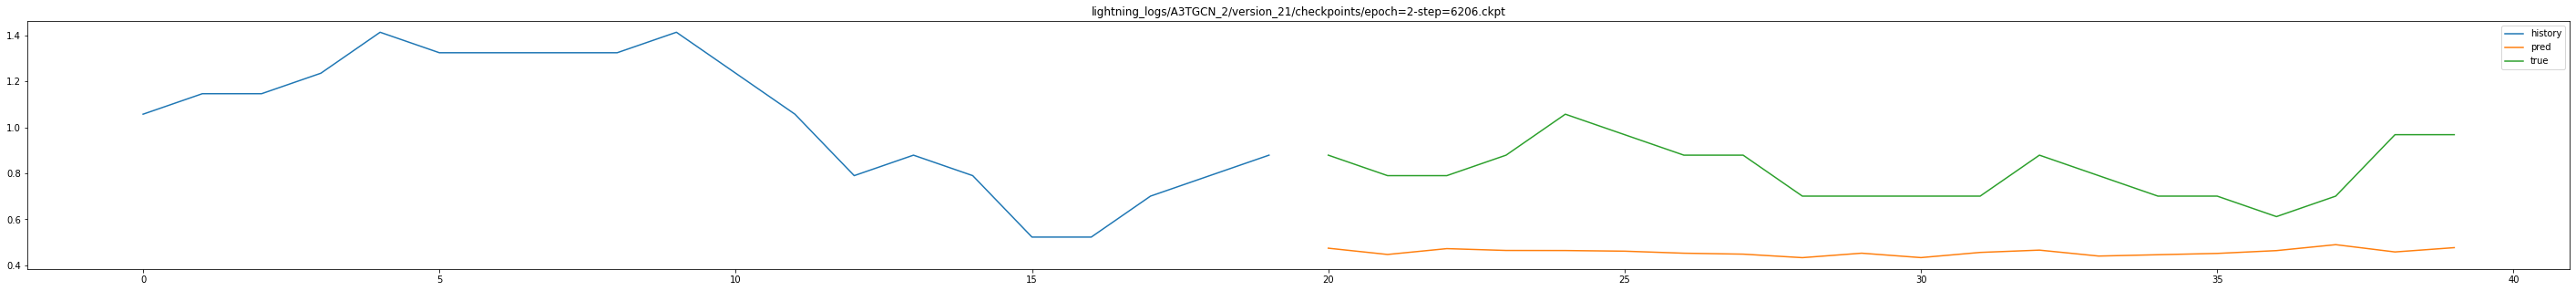

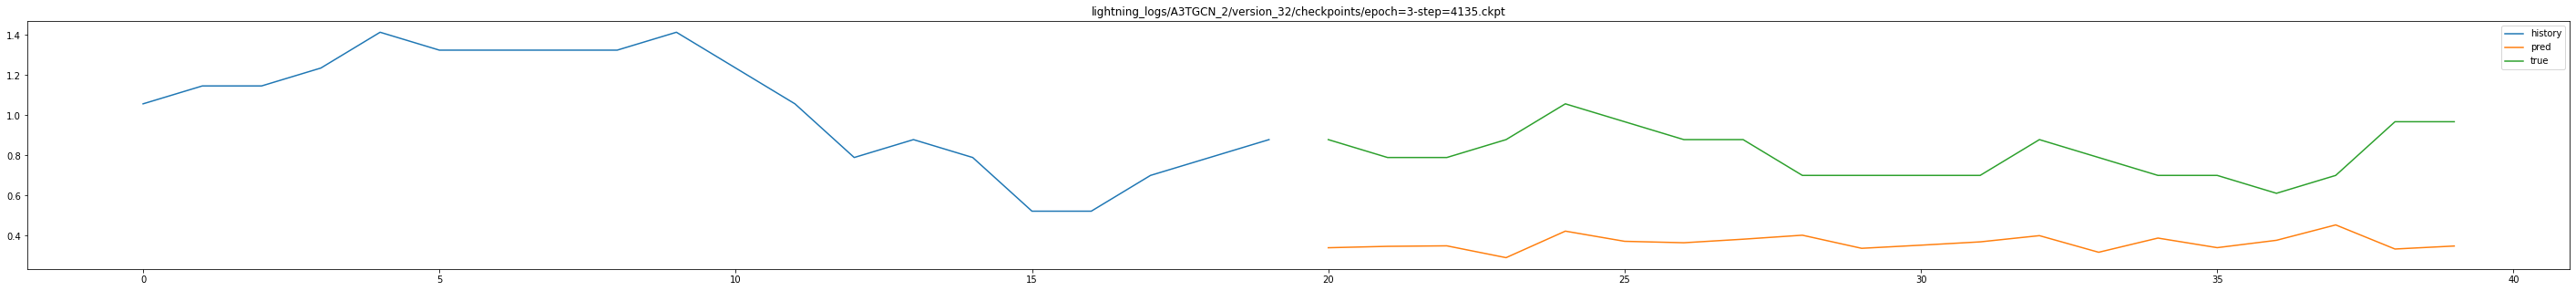

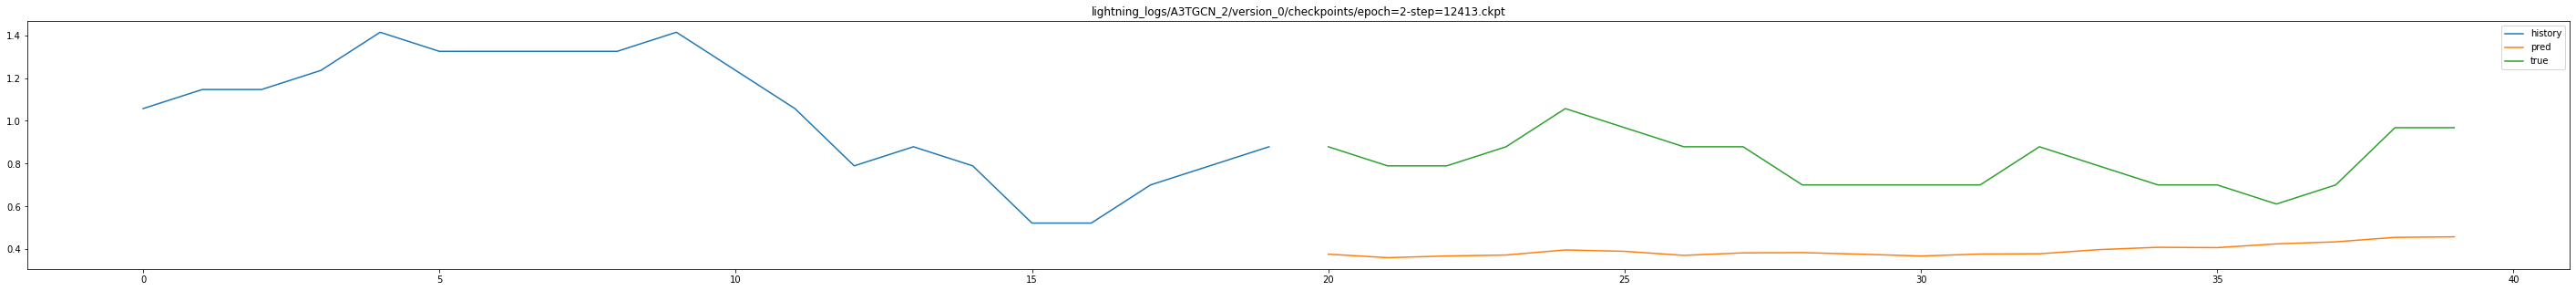

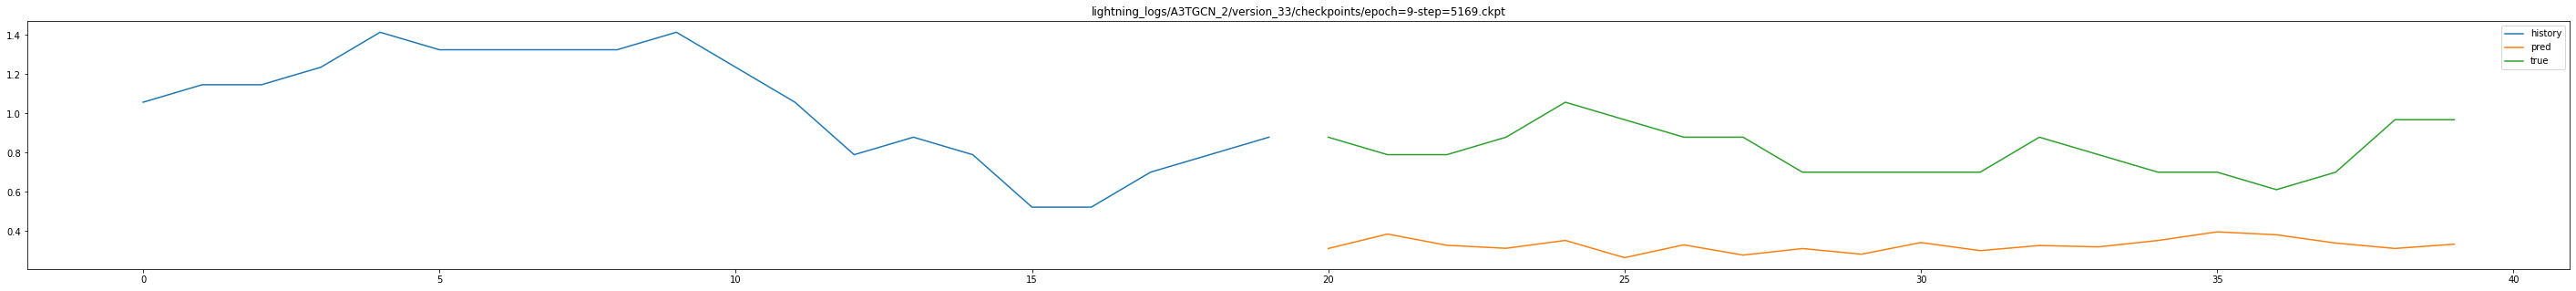

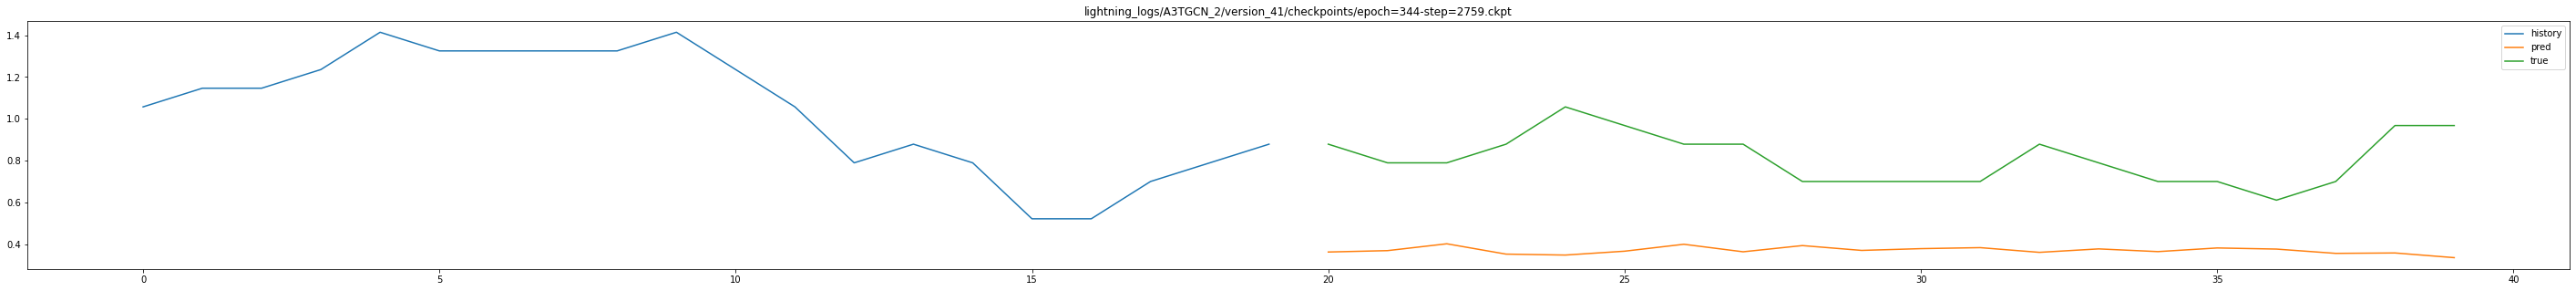

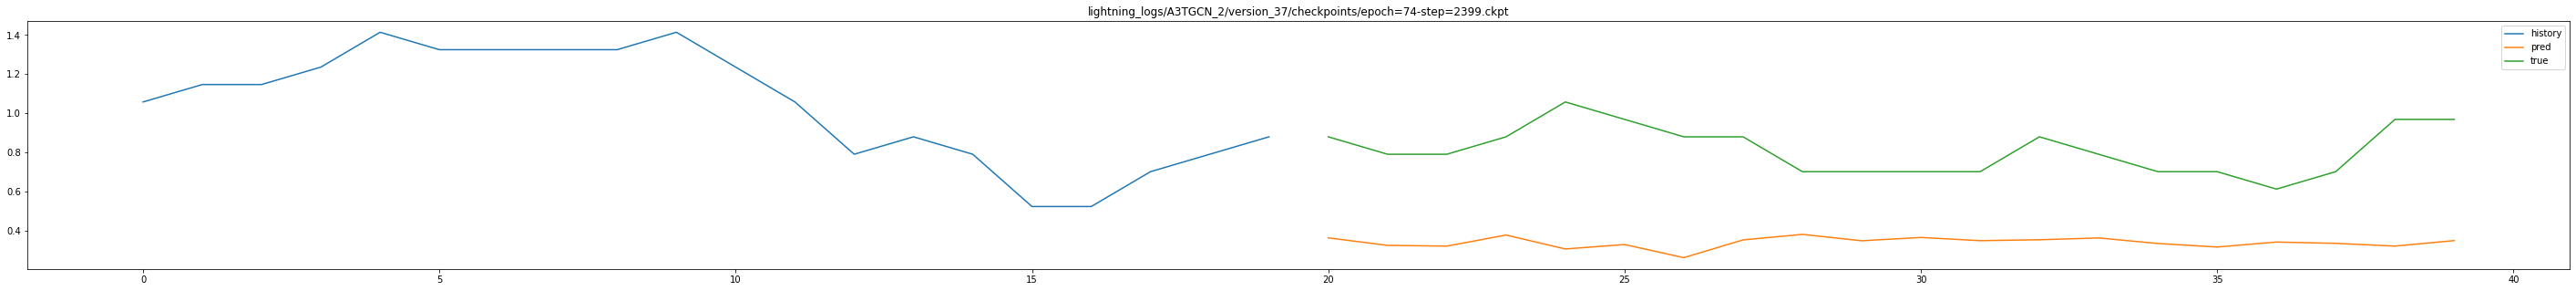

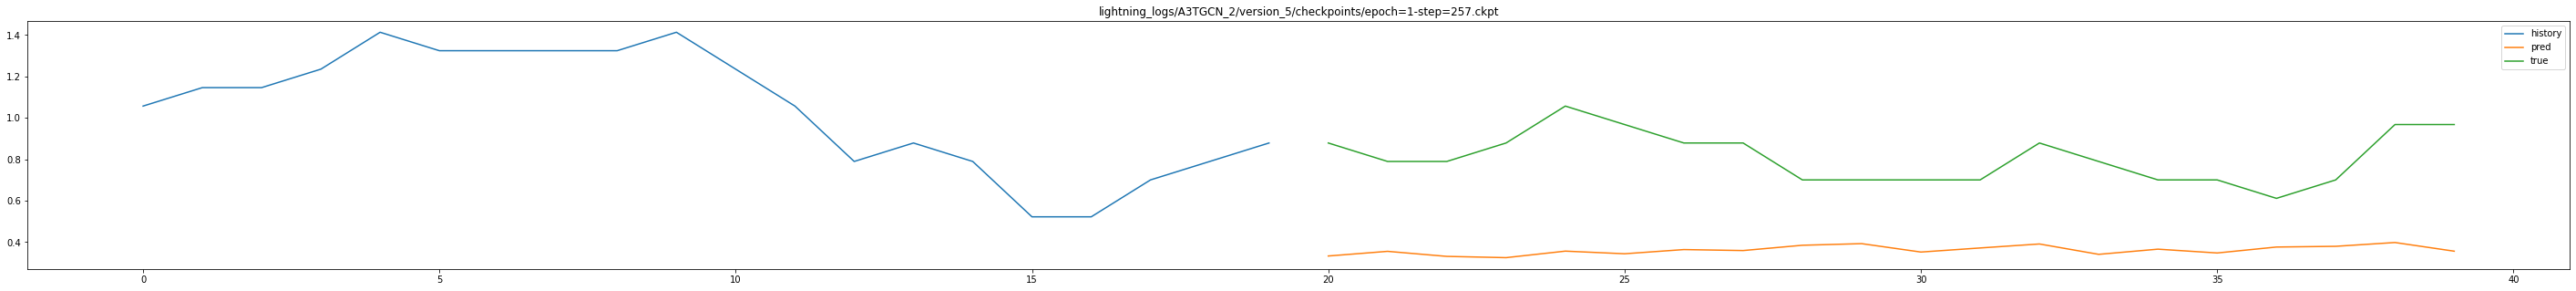

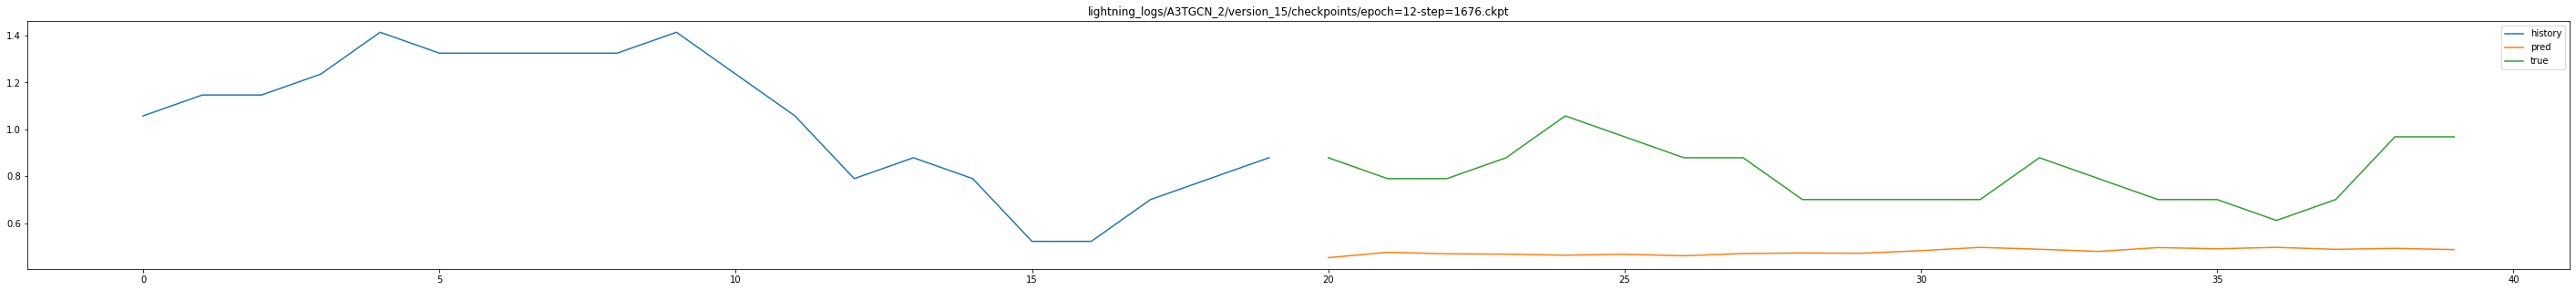

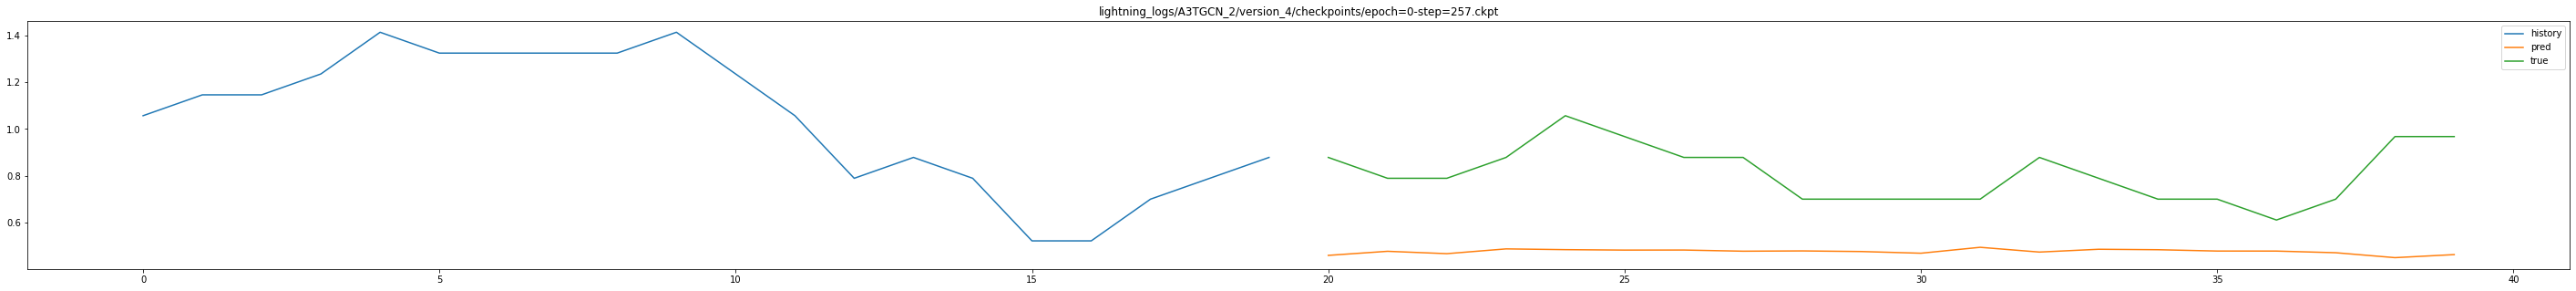

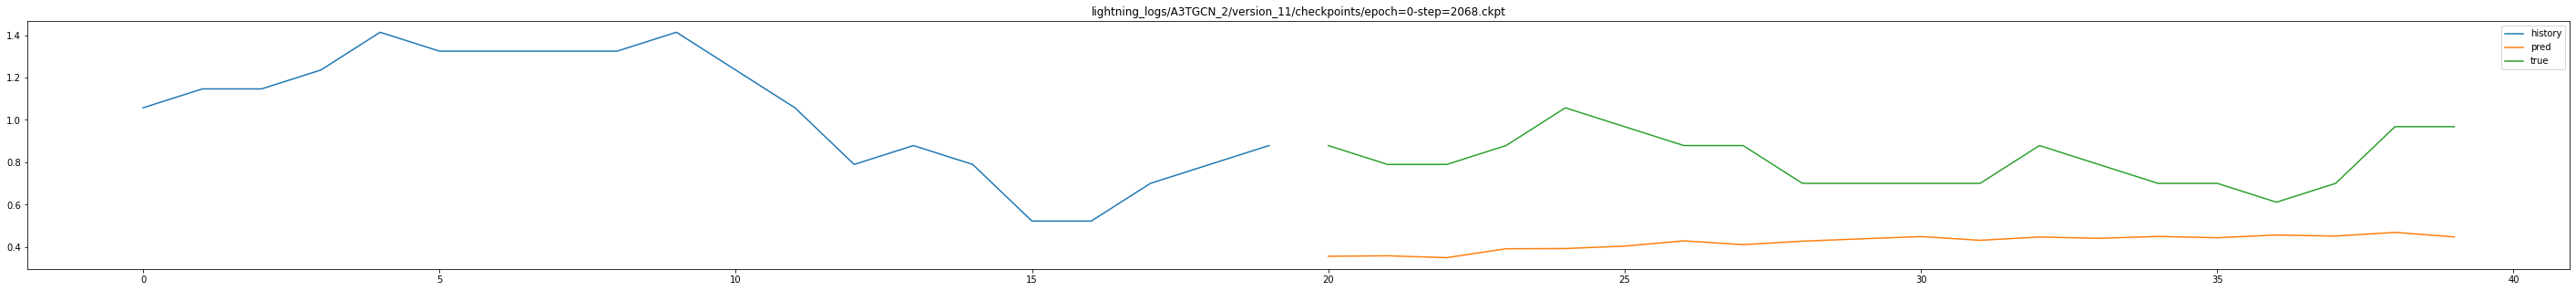

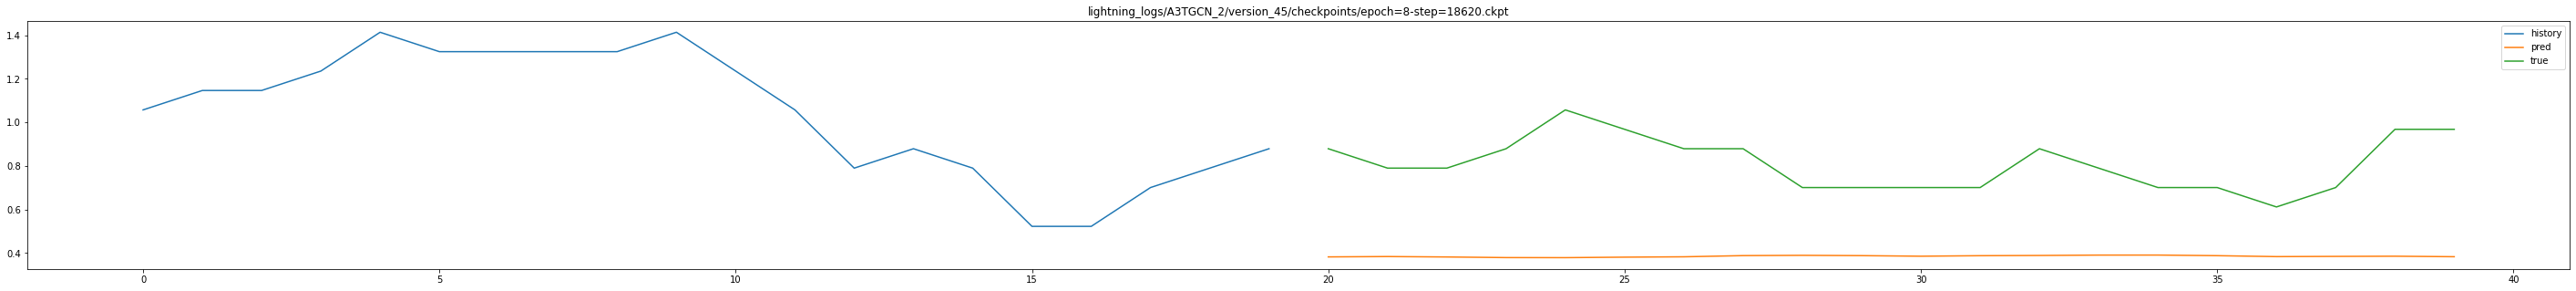

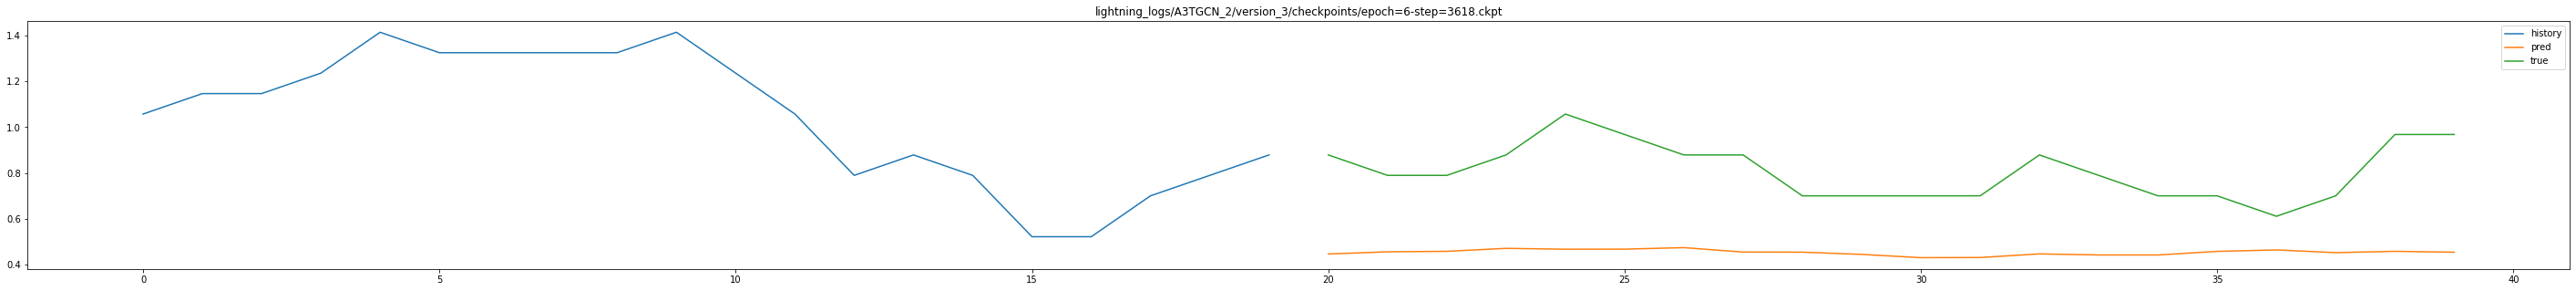

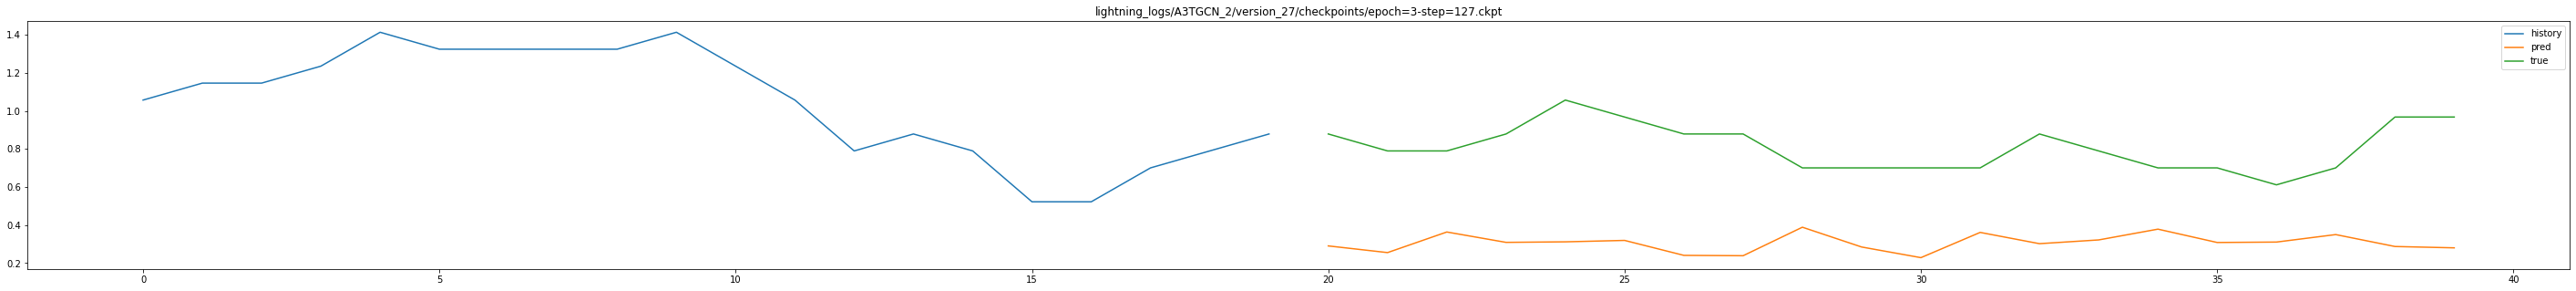

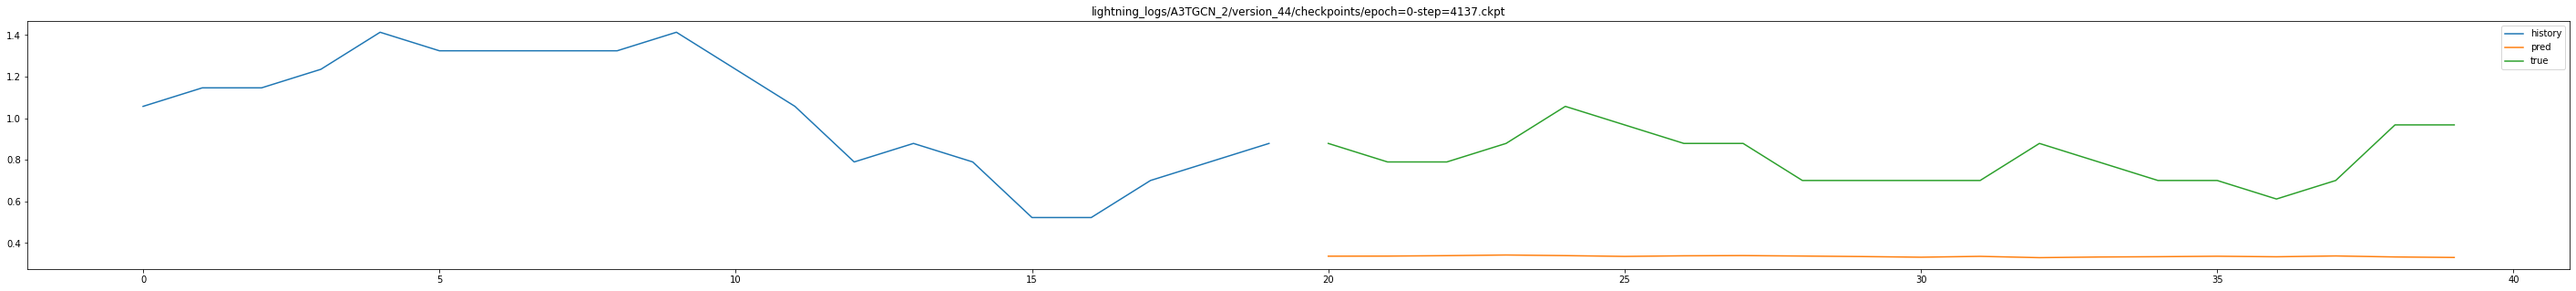

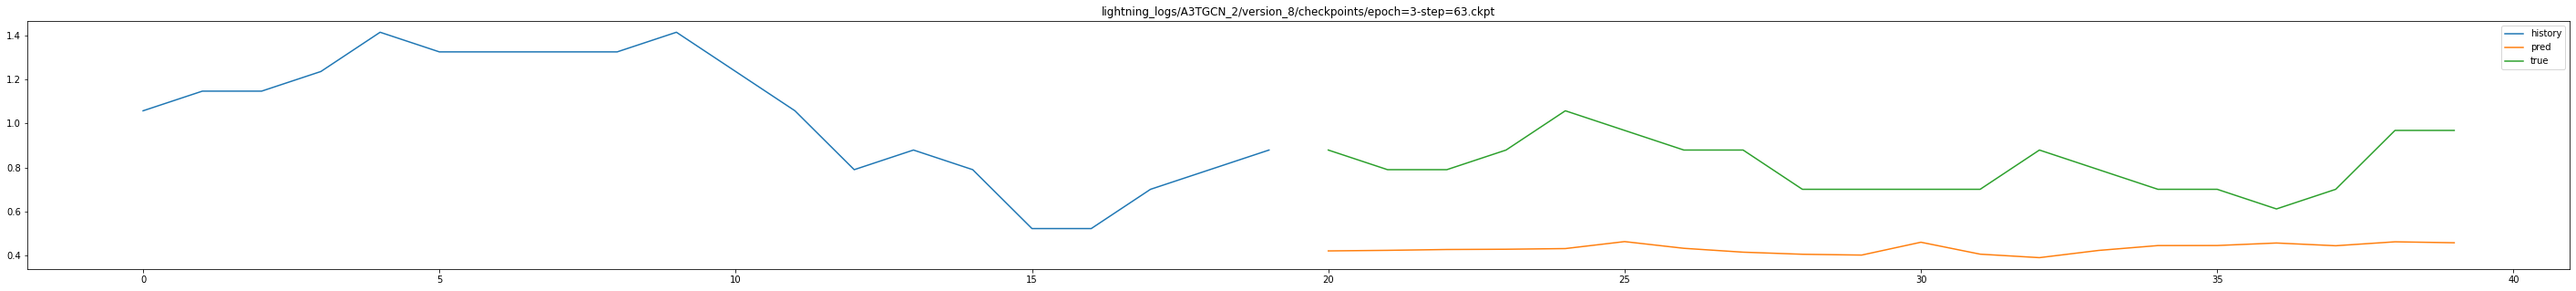

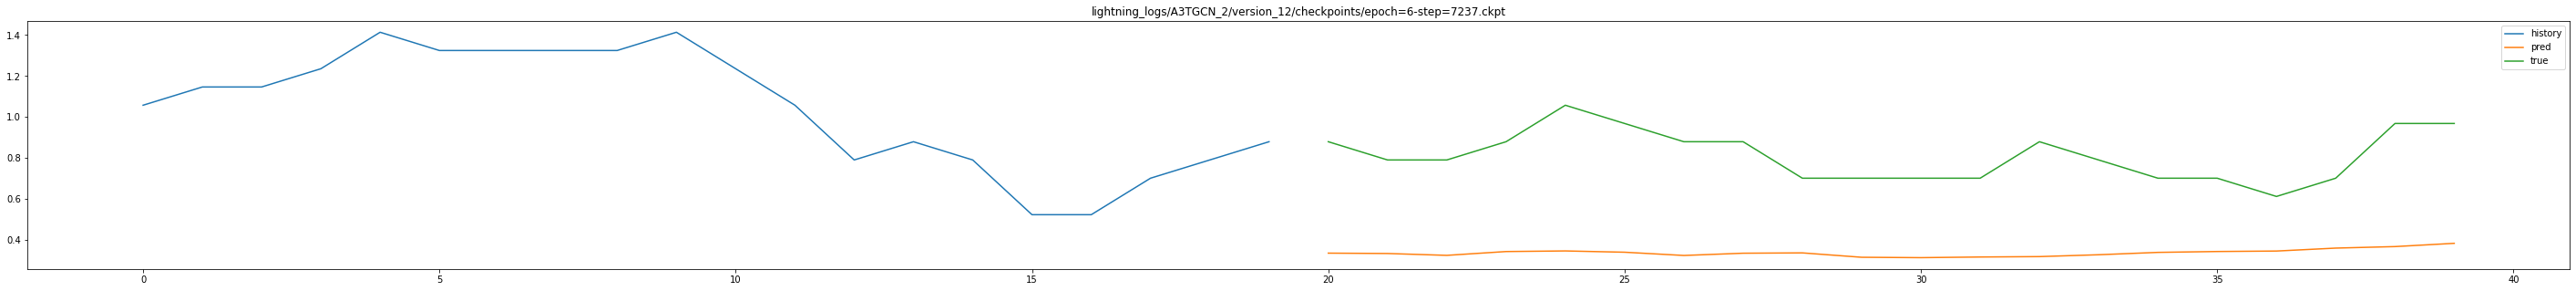

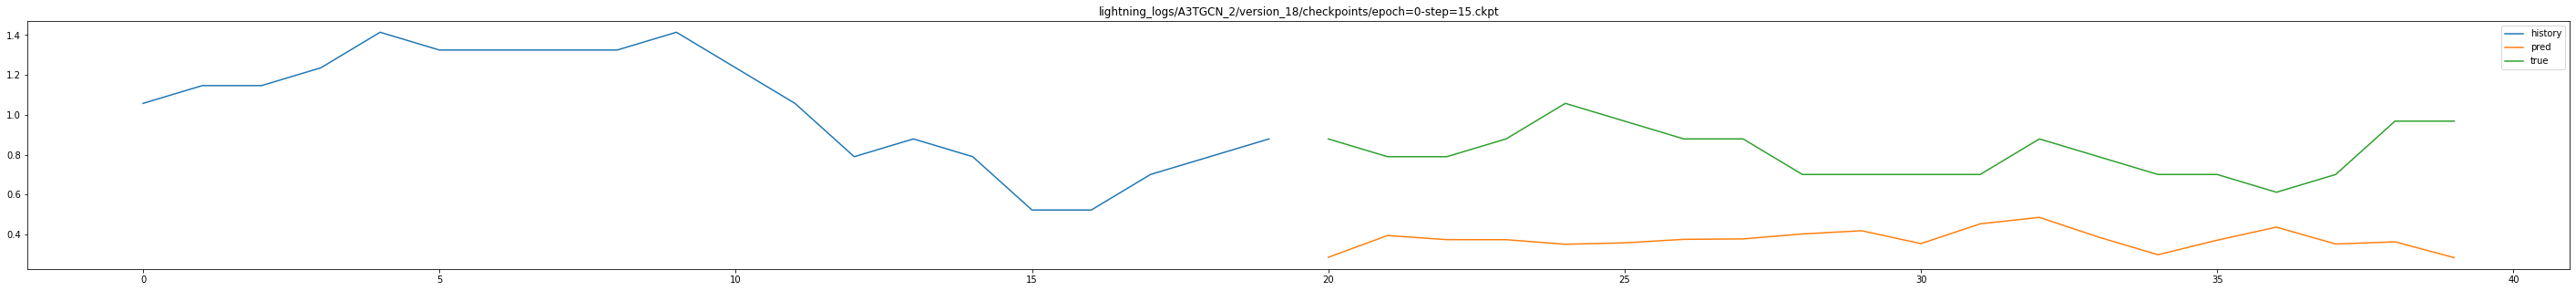

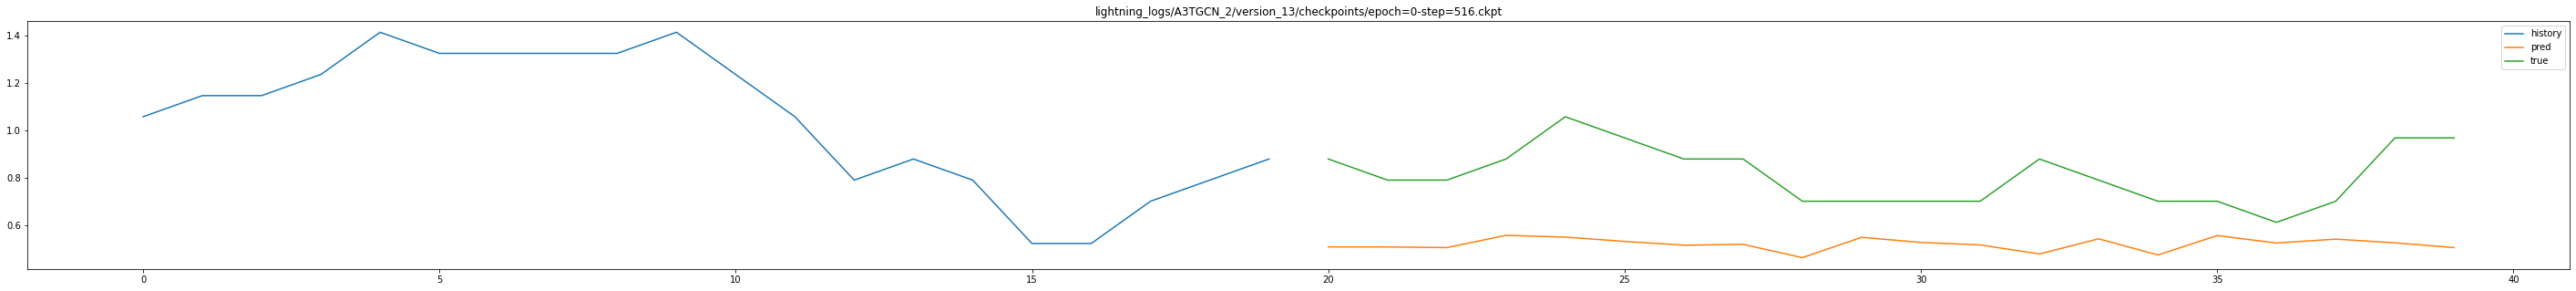

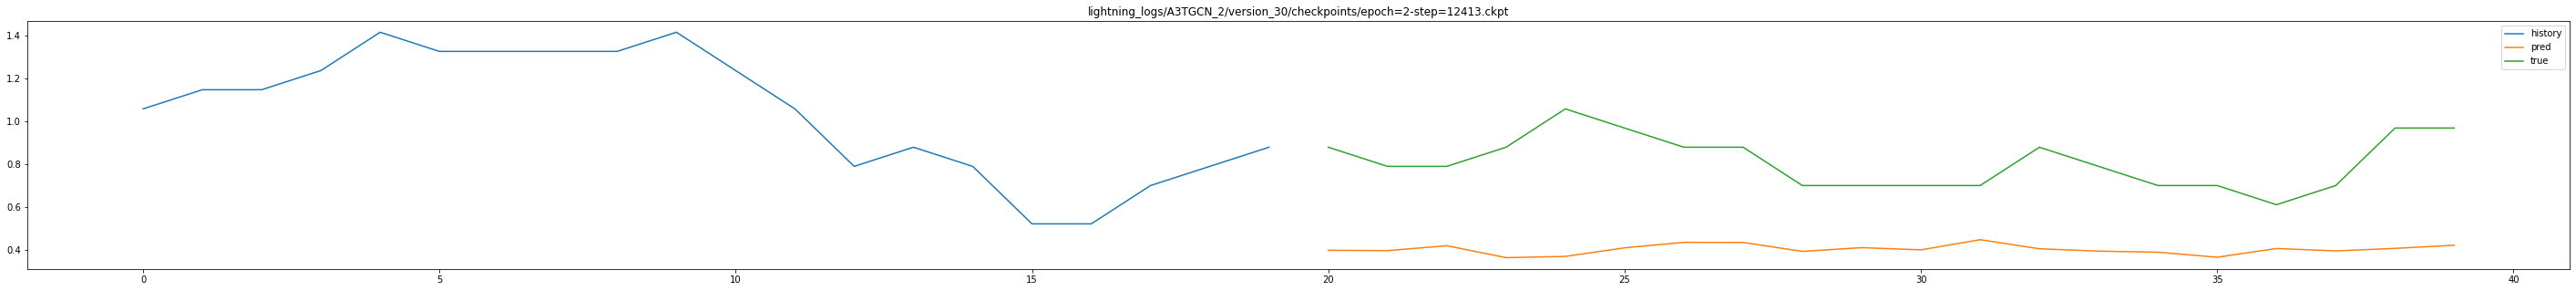

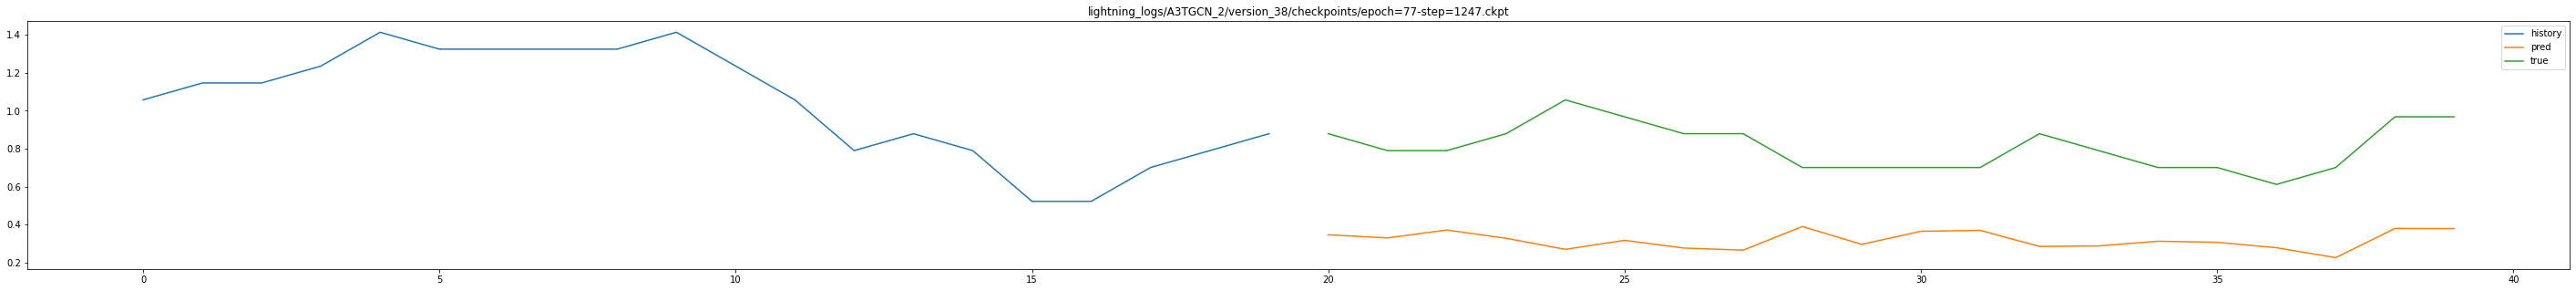

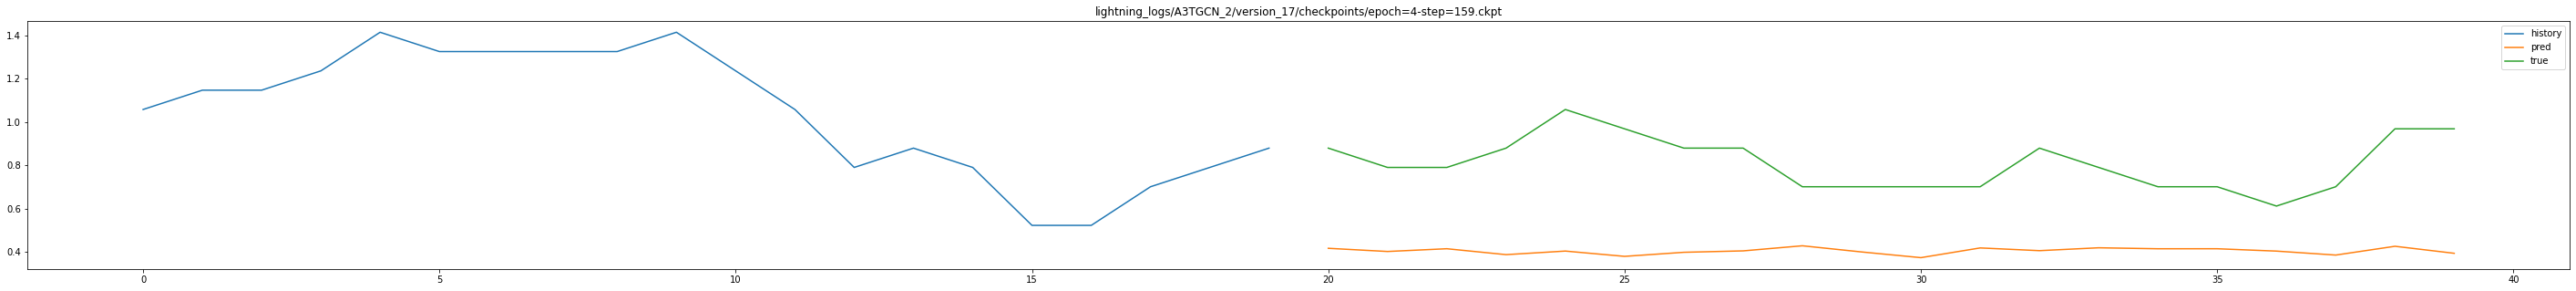

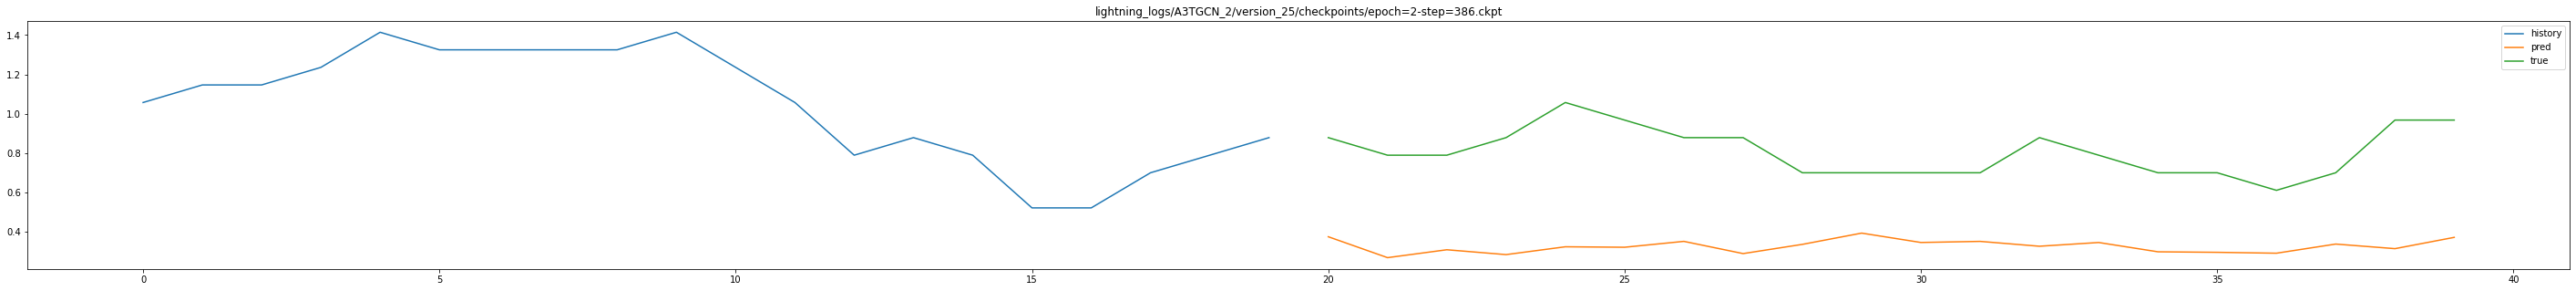

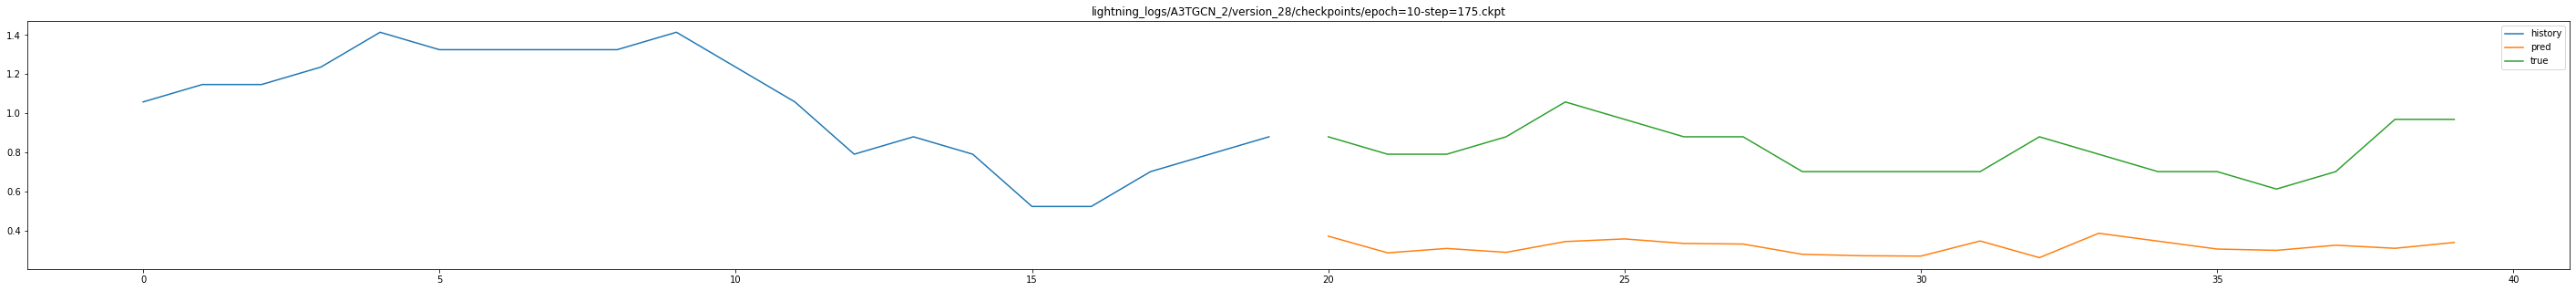

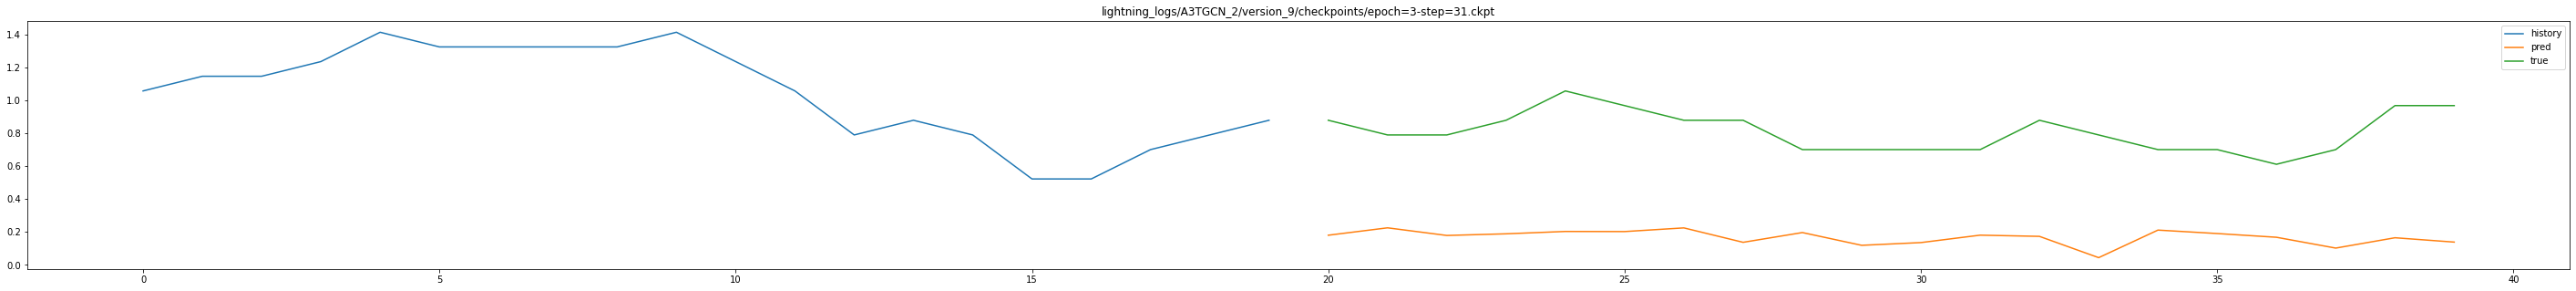

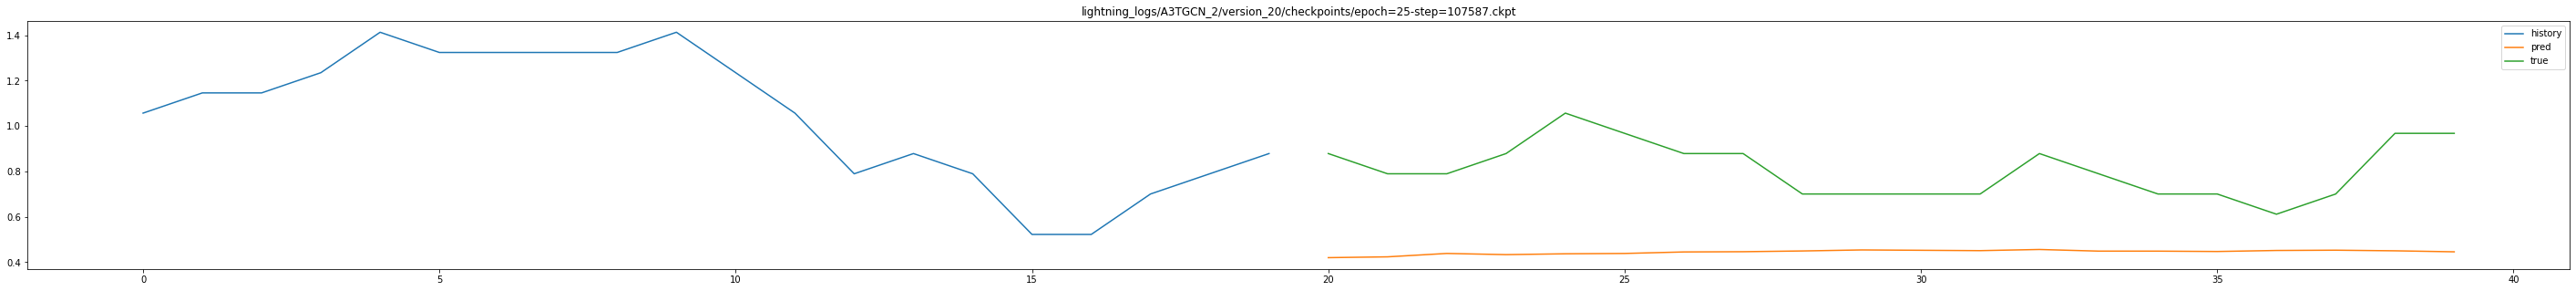

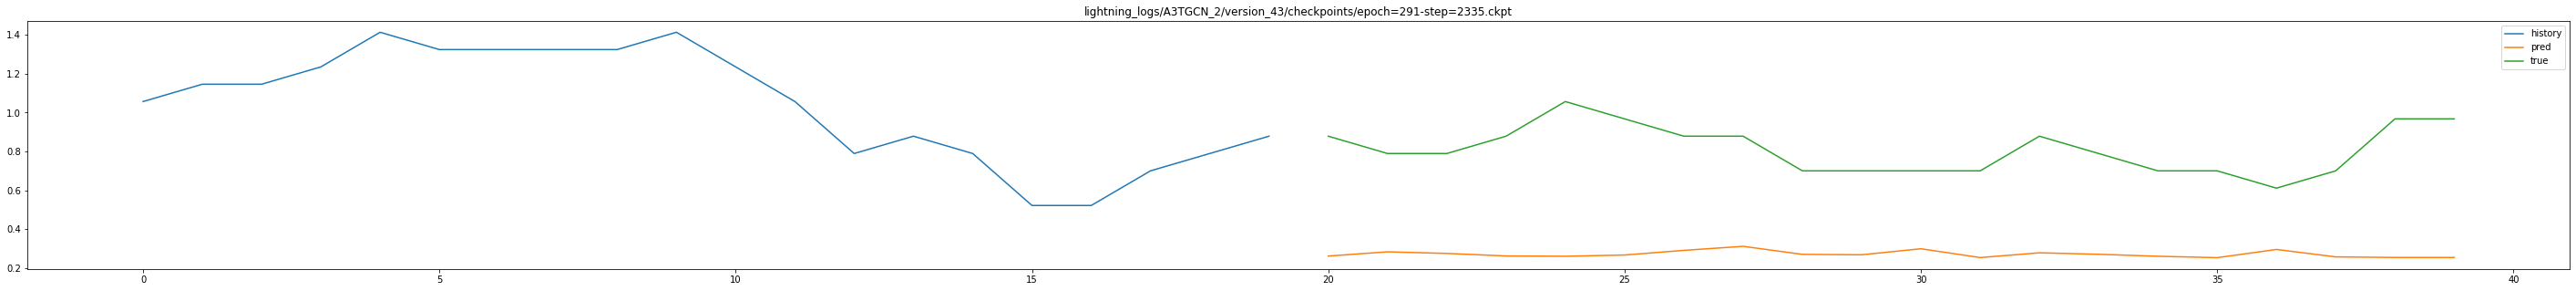

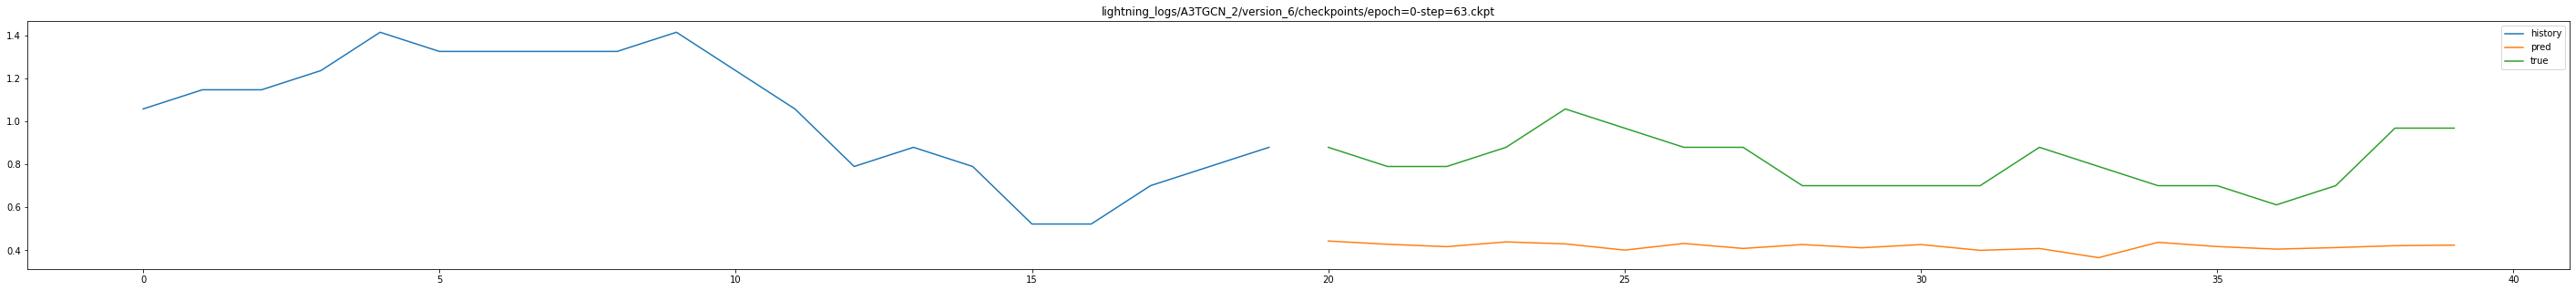

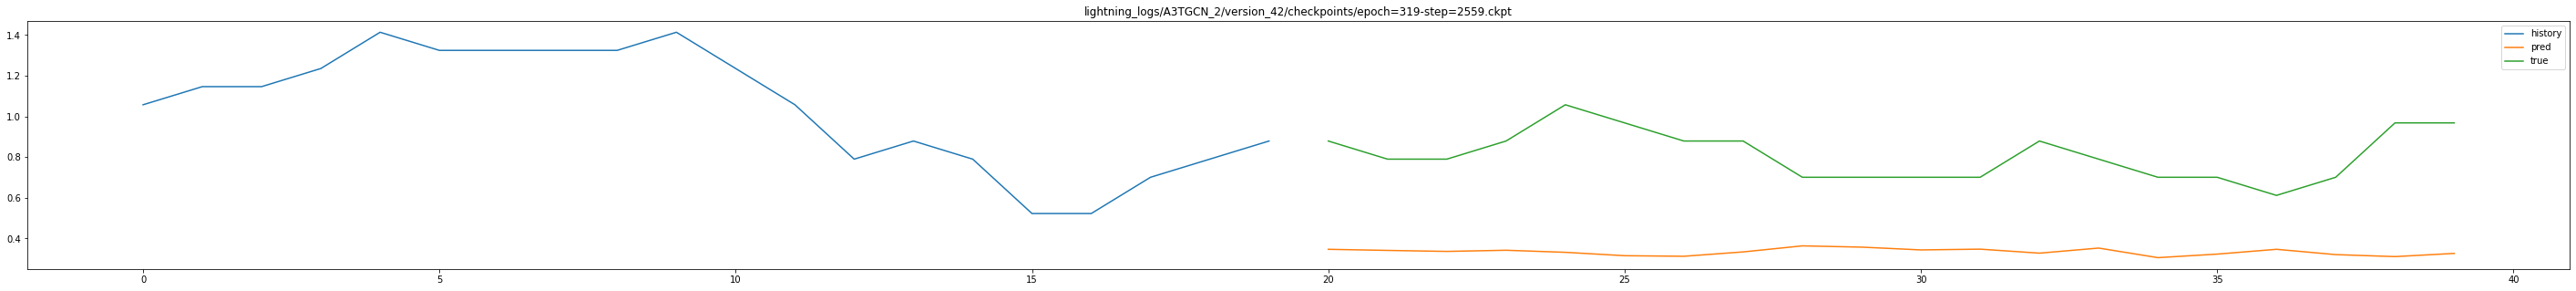

In [226]:
# plot all?
# testing all models
best_test_loss = 1e10

for root, dirs, files in tqdm(os.walk("lightning_logs")): 
    files = [f for f in files if not f[0] == '.']
    dirs[:] = [d for d in dirs if not d[0] == '.']
    
    if "version_" in root:
        for file in files:
            PATH = os.path.join(root, file)
            if file.endswith(".yaml"):
                # load hparams (should happen first before loading model & dm)
                hparams = load_hparams_from_yaml(PATH)

            if file.endswith(".ckpt") and ('last' not in file):
                # load model and datamodule
                datamodule = BatchLitDataModule(loader, 
                                                batch_size = hparams['batch_size'], 
                                                shuffle=False)
                datamodule.setup()

                m = A3TGCN_2(node_features=2, periods=20, batch_size=hparams['batch_size'])
                model = BatchLitWrapper.load_from_checkpoint(PATH,model=m)
                
                model.to('cpu')
                model.eval()
                model.freeze()
                for batch_idx, batch in enumerate(datamodule.test_dataloader()):
                    x, edge_index, edge_attr, _ = batch # x: (B, N, F, T)
                    h, labels = model._shared_step(batch, batch_idx) # h: (B, N, T); labels: (B, N, T)
#                     print(F.mse_loss(h, labels))
                    break
                    
                batch = 0
                zone = 5
                
                plt.figure(figsize=(50,5))
                plt.title(PATH)
                history = x[batch, zone, 0, :]
                preds = h[batch, zone, :]
                labs = labels[batch, zone, :]

                sns.lineplot(x=range(20), y=history, label="history")
                sns.lineplot(x=range(20,40), y=preds, label="pred")
                sns.lineplot(x=range(20,40), y=labs, label="true")

In [194]:
file

'epoch=0-step=516.ckpt'